# Experimental Setup

This notebook will use the data obtained from [GNFUV Unmanned Surface Vehicles Sensor Data Set 2 Data Set](https://archive.ics.uci.edu/ml/datasets/GNFUV+Unmanned+Surface+Vehicles+Sensor+Data+Set+2). This data set contains eight (2x4) data sets of mobile sensor readings data (humidity, temperature) corresponding to a swarm of four Unmanned Surface Vehicles (USVs) in a test-bed, Athens, Greece.

**Dataset characteristics**: Multivariate and Sequential 

**Attributes**:
* 'device' = USV ID (String)
* 'humidity' = sensed humidity value from the USV sensor (real value)
* temperature' = sensed temperature value from the USV sensor (real value)
* 'experiment' = 1 (constant real value)
* 'time' = the sensing and reporting time (real value)
* 'pi' = Raspberry Pi ID



In [1]:
# Global variable to control if activate all the verbose will be plotted.
debug=True

In [2]:
import os
import json
from datetime import datetime
from json import JSONDecodeError
import pandas as pd
import numpy as np

def generate_dataset(home_dir,dataset_name):
    
    """generate_dataset: This function assumes the data is 
    distributed in folders from a parent directory. 
    Each folder contains comma-separated files where each 
    row is defined with a JSON notation.
    Arguments:
        home_dir [string] -- parent directory
        dataset_name [ [string] ] -- Target folder name
    Returns:
        {data_df} -- Pandas dataframe with all the information joined,
                    cleaned and ready to use.
    """
    home_dir = home_dir +"/" + dataset_name
    pi_dirs = os.listdir(home_dir)
    data_list = []
    columns = None
    
    for pi_dir in pi_dirs:
        if 'pi' not in pi_dir:
            continue
        curr_dir = os.path.join(home_dir, pi_dir)
        data_file = os.path.join(curr_dir, os.listdir(curr_dir)[0])
        with open(data_file, 'r') as f:
            line = f.readline().strip().replace("'", '"')
            while line != '':
                try:
                    input_json = json.loads(line)
                    sensor_datetime = datetime.fromtimestamp(input_json['time'])
                    input_json['time'] = sensor_datetime
                    input_json['pi'] = pi_dir
                    data_list.append(list(input_json.values()))
                    if columns is None:
                        columns = list(input_json.keys())
                except JSONDecodeError as je:
                    pass
                line = f.readline().strip().replace("'", '"')
    
    data_df = pd.DataFrame(data_list, columns=columns)
    
    #@TODO: Include an argument to decide the target columns we want in the final dataset.
    del data_df['experiment']
    del data_df['device']
    del data_df['time']
    del data_df['pi']
    data_df = data_df.replace(to_replace=' None', value=np.nan).dropna()
    return data_df

## Building the dataset

* $D$ is the dataset with all the points.
* *target_columns* are the selected variables for this study ('temperature','humidity').
* if debug is activated, we perform some data checking to see the number of unique values at each column and any null or missing data. The function ```generate_dataset()```must prevent them.

In [3]:
home_dir = '../datasets'
dataset = 'GNFUV-USV-Dataset'

# This variable contains the name of the columns and represents the variables we want to study
xvar='temperature'
yvar='humidity'
target_columns=[xvar,yvar]

# D represents the global dataset (all the points).
D = generate_dataset(home_dir,dataset)

if debug:
    for t in target_columns:
        print(D[t].value_counts())
    print("Checking if there are any null or NAN value:")
    print(D.isnull().any())
    print((D.isnull().sum()/len(D.index))*100)
    

32.0    161
22.0    128
23.0    119
31.0    109
26.0    107
35.0    104
36.0     96
40.0     88
33.0     88
25.0     75
24.0     74
27.0     68
38.0     67
37.0     61
34.0     57
41.0     56
39.0     49
21.0     44
28.0     32
29.0     28
42.0     19
30.0     18
20.0      1
Name: temperature, dtype: int64
38.0    112
39.0    101
40.0     84
43.0     84
34.0     82
37.0     80
41.0     75
33.0     73
45.0     60
20.0     59
36.0     56
42.0     51
28.0     51
21.0     50
29.0     49
24.0     48
26.0     44
27.0     43
25.0     42
19.0     39
30.0     37
44.0     37
35.0     36
32.0     36
49.0     27
46.0     20
23.0     20
50.0     18
57.0     18
47.0     14
31.0     13
22.0     12
48.0     12
18.0     11
56.0     10
17.0     10
51.0      8
53.0      7
55.0      6
52.0      6
54.0      5
58.0      2
59.0      1
Name: humidity, dtype: int64
Checking if there are any null or NAN value:
humidity       False
temperature    False
dtype: bool
humidity       0.0
temperature    0.0
dtype: flo

### Distribution of $D$

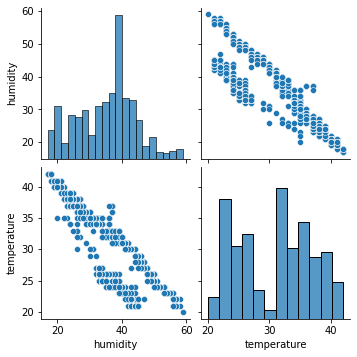

In [4]:
import seaborn as sns
# Plot the distribution (2D)
sns.pairplot(D, height=2.5);

## Outliers of $D$

<AxesSubplot:>

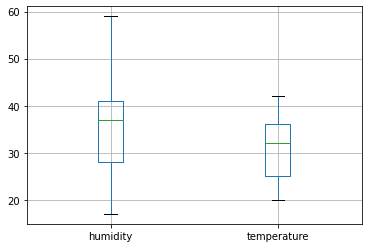

In [5]:
D.boxplot()

## Standaritzation of $D$ -> $\tilde D$

Make data consitent and normalized. $\tilde D$ is ```D_Scaled``` in the code.

array([[<AxesSubplot:title={'center':'humidity'}>,
        <AxesSubplot:title={'center':'temperature'}>]], dtype=object)

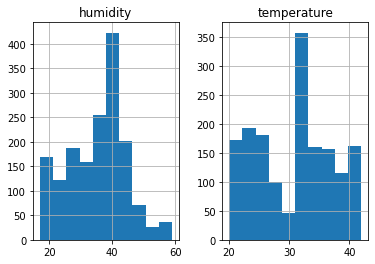

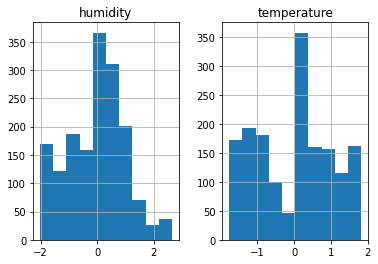

In [6]:
from sklearn.preprocessing import StandardScaler

standaritzation = StandardScaler()
standaritzation.fit(D[target_columns])
scaled=standaritzation.transform(D[target_columns])
D_Scaled = D.copy()
D_Scaled[target_columns] = scaled

D.hist()
D_Scaled.hist()

## Helper functions to train, test and explore models

To test the accuracy and performance of the model we use MSE and RMSE metrics. 

$$MSE = \frac{1}{n} \sum_{i=1}^{D}(y_i - \hat y_i)^2$$ 

where $y_i$ represent the *y-test* set and $\hat y_i$ the *y-predicted* using the model and $n$ the lenght of *y-test*.

$$RMSE = \sqrt(MSE)$$ 

**RMSE**: It represents the standard deviation of prediction errors. How far are the data points from the regression line.

*Note: It is hardcoded to SVR with specific configuration values.*

In [7]:
# Keys
Xtrain="xtrain"
Xtest="xtest"
Ytrain="ytrain"
Ytest="ytest"

def split_data(x,y, test_size=0.2):
    dd={}
    from sklearn.model_selection import train_test_split
    dd[Xtrain],dd[Xtest],dd[Ytrain],dd[Ytest]=train_test_split(x,y,test_size=test_size,random_state=42)
    return dd

def train_model(x_train, y_train, x_test, y_test):
    
    # svr is a support vector regression model
    from sklearn.svm import SVR
    svr = SVR(kernel='rbf', C=1, gamma=0.1, epsilon=0.1)
    model = svr.fit(x_train,y_train)
    score = model.score(x_test,y_test)
    
    if debug:
        print("SCORE:" + str(score))
        
    return model,score

def test_model(model,x_test,y_test):
    
    from sklearn.metrics import mean_squared_error
    from numpy import sqrt
    
    predictions = model.predict(x_test)
    y_predicted = pd.DataFrame(predictions, columns=['predicted'])
    
    mse = mean_squared_error(y_test, y_predicted)
    rmse = sqrt(mse)
    
    if debug:
        print("MSE:", mse)
        print("RMSE:", rmse)
    
    return mse,rmse,y_predicted

def plot_model(x_test,y_test,y_predicted,name='', x_name='x',y_name='y'):

    import matplotlib.pyplot as plt
    
    plt.scatter(x_test, y_test, c='tab:green', label='original')
    plt.plot(x_test, y_predicted, c='tab:red', label='predicted')
    
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    plt.title('Support Vector Regression ' +str(name))
    plt.legend()
    plt.show()
    

## Model $M$

Model with name M is the big brother. This model is trained using the whole training set belonging to $D$ or to $\tilde D$.

```models={}``` is a dictionary that contains information about a specific model, where name is the model name (i.e. $M$).

```json
name: {
     model: Trained model (SVR)
     score: Score obtained (scalar)
     mse: mean square error (scalar)
     rmse: root mean square error (scalar)
     prediction: y predicted values (Dataframe)
   }
```

SCORE:0.7552175527243686
MSE: 0.2589710915176694
RMSE: 0.5088920234368676


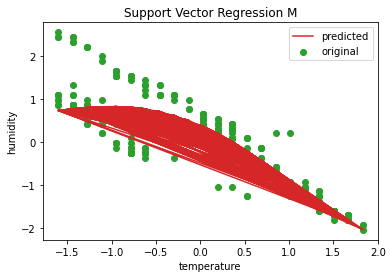

Accuracy of model: M === 75.52% (nº of correct predictions)"
Performance of model: M === 0.26 (MSE)
How far are the data points from the regression line: M === 0.51 (RMSE)


In [8]:
# _D represents a dictionary with the train and test data
X = D_Scaled.copy().drop(columns=[yvar])
y = D_Scaled[yvar].copy()
_D = split_data(X,y,test_size=0.2)

M="M"
models={}
models[M]={}
models[M]["model"],models["M"]["score"]= train_model(_D[Xtrain],_D[Ytrain],_D[Xtest],_D[Ytest])
models["M"]["mse"],models["M"]["rmse"],models["M"]["prediction"]=test_model(models["M"]["model"],_D[Xtest],_D[Ytest])
plot_model(_D[Xtest],_D[Ytest],models["M"]["prediction"],"M",xvar,yvar)

print('Accuracy of model: {} === {:.2f}% (nº of correct predictions)"'.format(M, models["M"]["score"]*100))
print('Performance of model: {} === {:.2f} (MSE)'.format(M, models["M"]["mse"]))
print('How far are the data points from the regression line: {} === {:.2f} (RMSE)'.format(M, models["M"]["rmse"]))

### Helpers to Data generation
This section aims to prepare the dataset to work with. The idea is to split the dataset into different groups to represent a node in our edge layer.

So, we want to represent our edge layer as a set of nodes ($n \in N$).
Each node $n$ in the edge layer will contain a unique subset of points from the full dataset $D$. Therefore, $D_{n}\subset D \;,\; \forall n \in N\;|\; D_n\not\subset D_m\;, \; \forall m \in N \;, \;m \neq n$.

This way, we use **KMeans** to generate different clusters and assign each cluster to a different node. *Note*: $K=N$

```generate_data```return a list of centroids and a dictionary $\hat D$:
```json
n0: {
     full: Dataframe 
     split: { 
         xtrain: Dataframe
         xtest: Dataframe
         ytrain: Dataframe
         ytest: Dataframe
     }
   },
nK: {
     full: Dataframe
     split: { 
         xtrain: Dataframe
         xtest: Dataframe
         ytrain: Dataframe
         ytest: Dataframe
     }
   }
```

In [23]:
# Needed for generating classification, regression and clustering datasets
import sklearn.datasets as dt
from sklearn.cluster import KMeans

def generate_data(dataset,n_clusters,x_name,y_name):
    from pandas import DataFrame
    import matplotlib.pyplot as plt
    from sklearn.cluster import KMeans

    kmeans = KMeans(n_clusters=n_clusters).fit(dataset)
    centroids = kmeans.cluster_centers_
    
    # We build a dictionary for each cluster with the corresponding dataframe using the position obtained in Kmeans
    # We split the x,y into train and test sets
    
    datasets = {}
    
    samples = {kmeans.cluster_centers_[i, 0]: np.where(kmeans.labels_ == i)[0] for i in range(kmeans.n_clusters)}

    nodes_index=0
    for k in samples.keys():
        datasets["n"+str(nodes_index)]={}
        d = dataset.iloc[samples[k], :]
        
        X=d.copy().drop(columns=[yvar])
        y=d[yvar].copy()
        
        datasets["n"+str(nodes_index)]["full"] = d
        datasets["n"+str(nodes_index)]["split"] = split_data(X,y,test_size=0.2)
        nodes_index = nodes_index +1
        
    return centroids, datasets, kmeans
    

def plot_nodes(dataset,centroids,x_name,y_name,kmeans):
    #TODO 0,1 1,0 FIX
    import matplotlib.pyplot as plt
    labels = ['n{0}'.format(i) for i in range(len(centroids))]
    plt_data = plt.scatter(dataset[x_name], dataset[y_name], c= kmeans.labels_.astype(float))
    plt.colorbar()
    plt.scatter(centroids[:, 1], centroids[:, 0], marker='x')
    plt.title('K-means clustering')
    plt.xlabel(x_name)
    plt.ylabel(y_name)
    labels = ['n{0}'.format(i) for i in range(K)]
    for i in range (K):
        xy=(centroids[i, 1],centroids[i, 1])
        plt.annotate(labels[i],xy, horizontalalignment='right', verticalalignment='top',
              bbox=dict(boxstyle='round,pad=0.2', fc='yellow', alpha=0.3),
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0.95', 
                                color='b'))

    plt.show()    

### Data Generation

{   'n0': {   'full':       humidity  temperature
363  -0.023229     0.194037
365   0.088447     0.357537
366   0.088447     0.357537
367   0.088447     0.357537
368   0.088447     0.357537
...        ...          ...
1644  0.535150     0.194037
1645  0.535150     0.194037
1646  0.535150     0.194037
1647  0.311798     0.194037
1648  0.535150     0.194037

[348 rows x 2 columns],
              'split': {   'xtest':       temperature
1555     0.357537
1414     0.194037
1615     0.357537
1568     0.357537
1467     0.030538
...           ...
1393     0.030538
1480     0.030538
1483     0.030538
1497     0.030538
1626     0.357537

[70 rows x 1 columns],
                           'xtrain':       temperature
1477     0.030538
1164     0.194037
1390     0.030538
1102    -0.132961
1152     0.194037
...           ...
1488     0.030538
1157     0.194037
1406     0.194037
1570     0.357537
1402     0.194037

[278 rows x 1 columns],
                           'ytest': 1555    0.423474
1414    0.

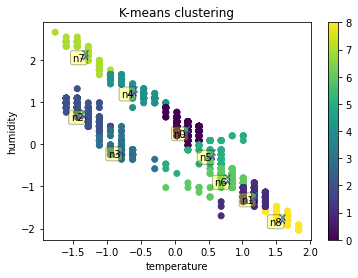

In [24]:
K=9
centroids,D_,kmeans = generate_data(D_Scaled,K,xvar,yvar)

if debug:
    import pprint
    pp = pprint.PrettyPrinter(indent=4)
    pp.pprint(D_)
    

plot_nodes(D_Scaled,centroids,xvar,yvar,kmeans)


### Distribution of $\hat D$

$\hat D$ represents the dictonary that contains the data at each node. For each node we have (full and split data).

Let us check the different distributions of each node concerning the two variables studied, humidity and temperature.

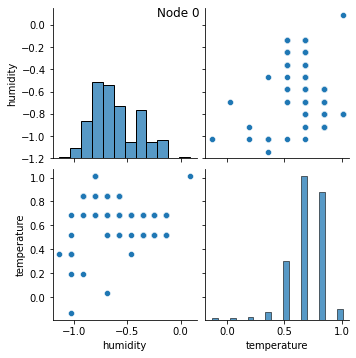

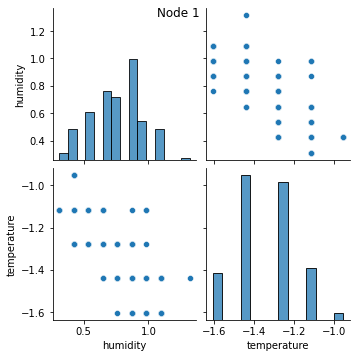

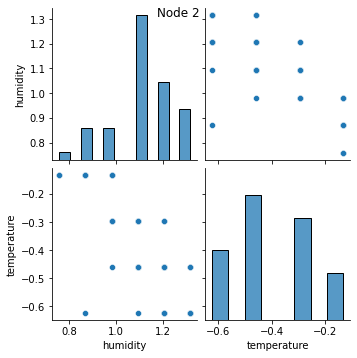

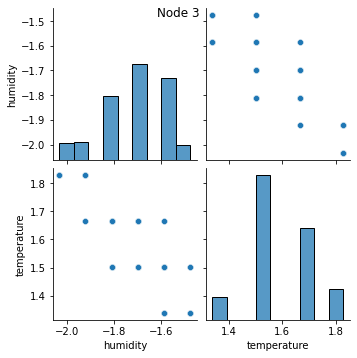

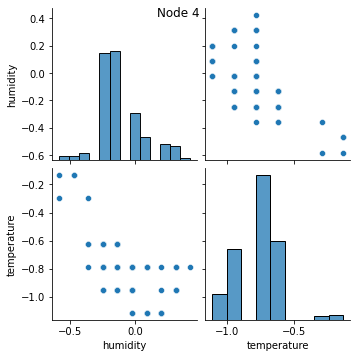

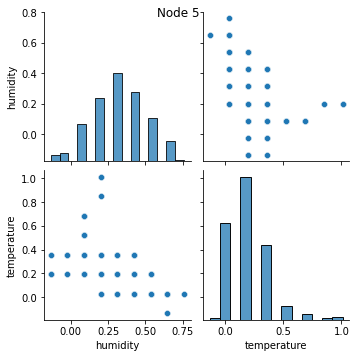

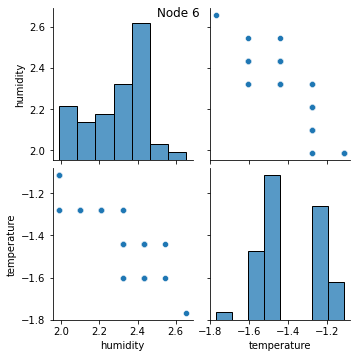

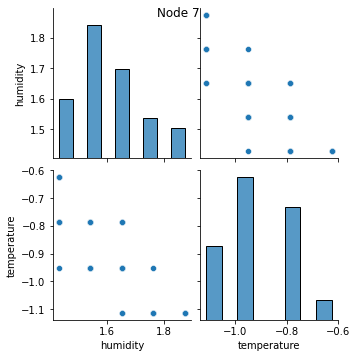

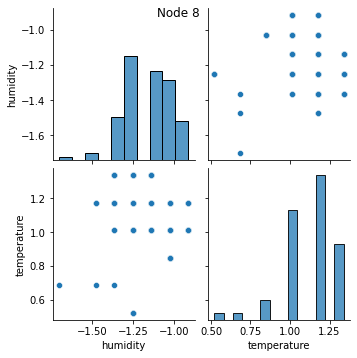

In [11]:
i=0
for k in D_.keys():
    g = sns.pairplot(D_[k]["full"], height=2.5);
    g.fig.suptitle("Node "+str(i)) 
    i=i+1

# Generating the models $m_i$

We are going to add to ```models``` dictionary a new model for each $N$ dataset. Therefore, $m_i \; | \; \forall i \in N$:

SCORE:-0.07126656419833499
MSE: 0.04617129533643053
RMSE: 0.21487506913653462


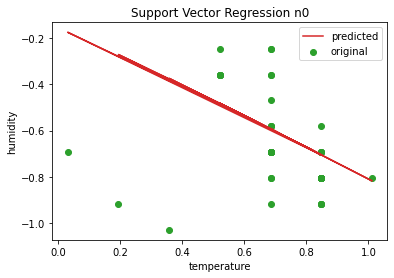

Accuracy of model: n0 === -7.13% (nº of correct predictions)"
Performance of model: n0 === 0.05 (MSE)
How far are the data points from the regression line: M === 0.21 (RMSE)
SCORE:0.5132234870219594
MSE: 0.02250094191448483
RMSE: 0.15000313968209075


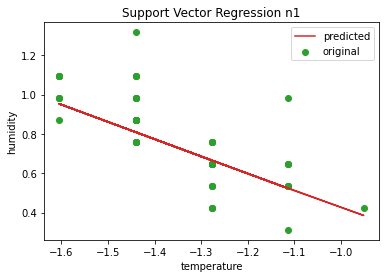

Accuracy of model: n1 === 51.32% (nº of correct predictions)"
Performance of model: n1 === 0.02 (MSE)
How far are the data points from the regression line: M === 0.15 (RMSE)
SCORE:0.6050607639396881
MSE: 0.010398230546315989
RMSE: 0.10197171444236872


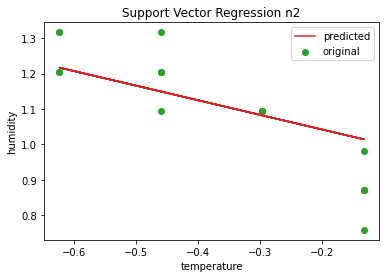

Accuracy of model: n2 === 60.51% (nº of correct predictions)"
Performance of model: n2 === 0.01 (MSE)
How far are the data points from the regression line: M === 0.10 (RMSE)
SCORE:0.5588727828888598
MSE: 0.005654329935753842
RMSE: 0.07519527867994003


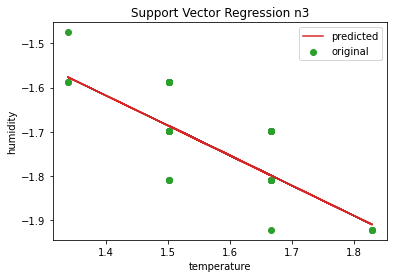

Accuracy of model: n3 === 55.89% (nº of correct predictions)"
Performance of model: n3 === 0.01 (MSE)
How far are the data points from the regression line: M === 0.08 (RMSE)
SCORE:0.2550379273575488
MSE: 0.019473379621377913
RMSE: 0.1395470516398606


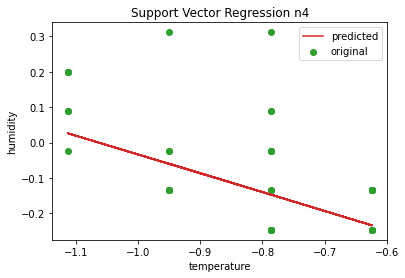

Accuracy of model: n4 === 25.50% (nº of correct predictions)"
Performance of model: n4 === 0.02 (MSE)
How far are the data points from the regression line: M === 0.14 (RMSE)
SCORE:0.25871239276490443
MSE: 0.03025097859321797
RMSE: 0.1739280845442103


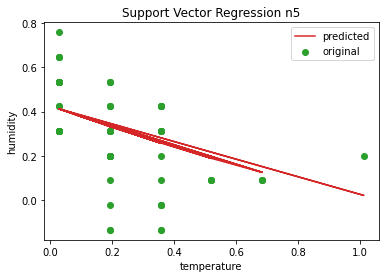

Accuracy of model: n5 === 25.87% (nº of correct predictions)"
Performance of model: n5 === 0.03 (MSE)
How far are the data points from the regression line: M === 0.17 (RMSE)
SCORE:0.5355407655914189
MSE: 0.015118412066601033
RMSE: 0.12295695208730995


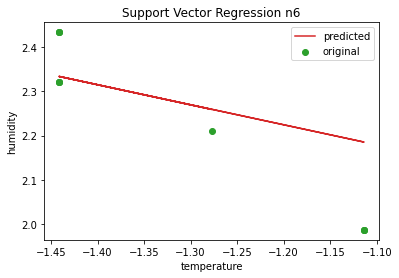

Accuracy of model: n6 === 53.55% (nº of correct predictions)"
Performance of model: n6 === 0.02 (MSE)
How far are the data points from the regression line: M === 0.12 (RMSE)
SCORE:0.3589855304663917
MSE: 0.014354390240979408
RMSE: 0.11980980861757275


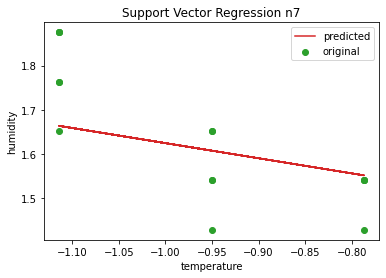

Accuracy of model: n7 === 35.90% (nº of correct predictions)"
Performance of model: n7 === 0.01 (MSE)
How far are the data points from the regression line: M === 0.12 (RMSE)
SCORE:0.004959721947953466
MSE: 0.028007540638987662
RMSE: 0.16735453575863327


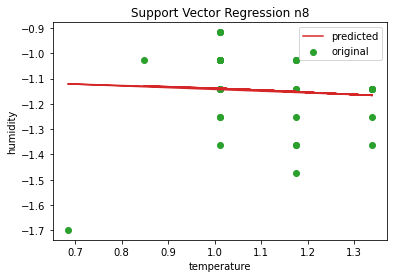

Accuracy of model: n8 === 0.50% (nº of correct predictions)"
Performance of model: n8 === 0.03 (MSE)
How far are the data points from the regression line: M === 0.17 (RMSE)


In [12]:
index_model=0

for k in D_.keys():
    
    # ni is the node i
    ni = "n"+str(index_model)
    
    # di is the dataset corresponding to node i
    di=D_["n"+str(index_model)]["split"]
    
    models[ni]={}
    models[ni]["model"],models[ni]["score"] = train_model(di[Xtrain],di[Ytrain],di[Xtest],di[Ytest])
    models[ni]["mse"],models[ni]["rmse"],models[ni]["prediction"]=test_model(models[ni]["model"],di[Xtest],di[Ytest])
    plot_model(di[Xtest],di[Ytest],models[ni]["prediction"],ni,xvar,yvar)


    print('Accuracy of model: {} === {:.2f}% (nº of correct predictions)"'.format(ni, models[ni]["score"]*100))
    print('Performance of model: {} === {:.2f} (MSE)'.format(ni, models[ni]["mse"]))
    print('How far are the data points from the regression line: {} === {:.2f} (RMSE)'.format(M, models[ni]["rmse"]))

    index_model = index_model +1

In [13]:
def generate_outsiders(datasets,strategy,outer):
    import copy
    output={}
    if (strategy == 'percentile' or strategy == 'random'):
        percentile = ((100/outer)/100) - 0.01
        
        index_model=0
        for k in datasets.keys():
            # ni is the node i
            ni = "n"+str(index_model)
            # di is the dataset corresponding to node i
            di=datasets[ni]

            output[ni]= copy.deepcopy(di)

            index_outer_model = 0
            for ko in datasets.keys():
                # nko is the node ko
                nko = "n"+str(index_outer_model)
                # dko is the dataset corresponding to node ko
                dko = datasets[nko]
                
                if (index_model != index_outer_model):
                    
                    nx=output[ni]["split"][Xtrain].values.tolist()
                    ny=output[ni]["split"][Ytrain].values.tolist()
                    
                    for o in range(outer):
                        if (strategy == 'percentile'):
                            v =  percentile + (percentile*o)
                            vDf = pd.DataFrame(dko["full"].quantile(v)).T
                        elif (strategy == 'random'):
                            vDf = pd.DataFrame(dko["full"].sample())
                            
                        nx.append([vDf.iloc[:,1].values[0]])
                        ny.append(vDf.iloc[:,0].values[0])
                    
                    dfx = pd.DataFrame(nx,columns=[xvar])
                    dfy = pd.Series(ny)
                    
                

                            
                    #xt=output[ni]["split"][Xtrain]
                    #yt=output[ni]["split"][Ytrain]
                        
                        #output[ni]["split"][Xtrain]=pd.concat([
                         #   xt, pd.DataFrame(vDf.iloc[:,1].values)],ignore_index=True)
                            
                        #xt.loc[len(xt.index)] = vDf.iloc[:,1].values[0].copy()
                        #yt.loc[len(yt.index)] = vDf.iloc[:,0].values[0].copy()
                    #del output[ni]["split"][Xtrain]
                    #del output[ni]["split"][Ytrain]
                    output[ni]["split"][Xtrain] = dfx.copy()
                    output[ni]["split"][Ytrain] = dfy.copy()
                
                index_outer_model = index_outer_model +1
            index_model = index_model + 1
                                      
    else:
        raise ValueError("Wrong strategy. Strategy must be ['random','percentile']")
             
    return output


In [14]:
outers = 5
#print(len(D_['n0']["split"][Xtrain]))
data=D_.copy()
DO_=generate_outsiders(data,'percentile',outers)
#print(len(D_['n0']["split"][Xtrain]))
#print(len(DO_['n0']["split"][Xtrain]))

print(type(D_['n0']["split"][Xtrain]))
print(type(DO_['n0']["split"][Xtrain]))
print((D_['n0']["split"][Ytrain]))
print((DO_['n0']["split"][Ytrain]))

print("+++ Testing generate_outsiders():")

index_model=0
for k in D_.keys():
    # ni is the node i
    ni = "n"+str(index_model)
    # di is the dataset corresponding to node i
    di=D_[ni]
    # di is the dataset with outsider corresponding to node i
    doi=DO_[ni]
    
    if (len(di["split"][Xtrain]) + (K-1) * outers == len(doi["split"][Xtrain])):
        print("Passed in node {} (Xtrain) -> {} != {}".format(index_model,
              len(di["split"][Xtrain])  + (K-1) * outers,
              len(doi["split"][Xtrain]))
            )
    else:
        print("Error in node {} (Xtrain) -> {} == {}".format(index_model,
              len(di["split"][Xtrain]) + (K-1) * outers,
              len(doi["split"][Xtrain]))
            )
    if (len(di["split"][Ytrain]) + (K-1) * outers == len(doi["split"][Ytrain])):
        print("Passed in node {} (Ytrain) -> {} != {}".format(index_model, 
              len(di["split"][Ytrain] ) + (K-1) * outers,
              len(doi["split"][Ytrain]))
            )
    else:
        print("Error in node {} (Ytrain)-> {} == {}".format(index_model,
              len(di["split"][Ytrain]) + (K-1) * outers,
              len(doi["split"][Ytrain]))
            )
    
    index_model = index_model + 1 

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>
354    -0.134905
1203   -0.358256
1196   -0.358256
1206   -0.358256
1382   -0.804960
          ...   
343    -0.358256
48     -0.804960
329    -1.028311
1227   -0.469932
339    -0.581608
Name: humidity, Length: 188, dtype: float64
0     -0.134905
1     -0.358256
2     -0.358256
3     -0.358256
4     -0.804960
         ...   
223   -1.251663
224   -1.251663
225   -1.139987
226   -1.028311
227   -0.916635
Length: 228, dtype: float64
+++ Testing generate_outsiders():
Passed in node 0 (Xtrain) -> 228 != 228
Passed in node 0 (Ytrain) -> 228 != 228
Passed in node 1 (Xtrain) -> 273 != 273
Passed in node 1 (Ytrain) -> 273 != 273
Passed in node 2 (Xtrain) -> 110 != 110
Passed in node 2 (Ytrain) -> 110 != 110
Passed in node 3 (Xtrain) -> 181 != 181
Passed in node 3 (Ytrain) -> 181 != 181
Passed in node 4 (Xtrain) -> 192 != 192
Passed in node 4 (Ytrain) -> 192 != 192
Passed in node 5 (Xtrain) -> 342 != 342
Passed in node 

## Training the models with outsiders

We train the models using the new datasets including outsiders.

SCORE:-0.5114640410296278
MSE: 0.06514368595177532
RMSE: 0.2552326114582055


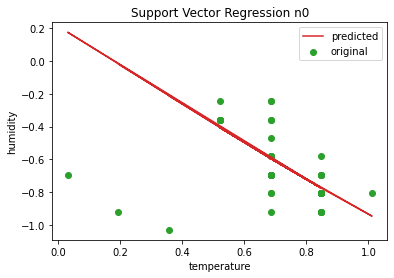

Accuracy of model: n0 === -51.15% (nº of correct predictions)"
Performance of model: n0 === 0.07 (MSE)
How far are the data points from the regression line: M === 0.26 (RMSE)
SCORE:0.41954319584151545
MSE: 0.026831255177726204
RMSE: 0.16380248831359737


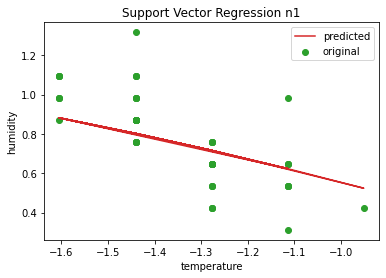

Accuracy of model: n1 === 41.95% (nº of correct predictions)"
Performance of model: n1 === 0.03 (MSE)
How far are the data points from the regression line: M === 0.16 (RMSE)
SCORE:0.6884768346715637
MSE: 0.00820199513706588
RMSE: 0.09056486701290893


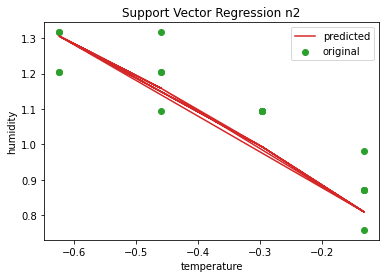

Accuracy of model: n2 === 68.85% (nº of correct predictions)"
Performance of model: n2 === 0.01 (MSE)
How far are the data points from the regression line: M === 0.09 (RMSE)
SCORE:0.453202839631183
MSE: 0.0070087979900810265
RMSE: 0.08371856419027399


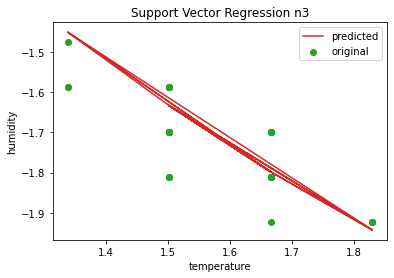

Accuracy of model: n3 === 45.32% (nº of correct predictions)"
Performance of model: n3 === 0.01 (MSE)
How far are the data points from the regression line: M === 0.08 (RMSE)
SCORE:0.32997305693097434
MSE: 0.017514568188220794
RMSE: 0.13234261667437588


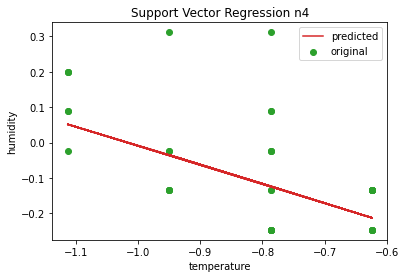

Accuracy of model: n4 === 33.00% (nº of correct predictions)"
Performance of model: n4 === 0.02 (MSE)
How far are the data points from the regression line: M === 0.13 (RMSE)
SCORE:0.18970553300575
MSE: 0.03306705836709354
RMSE: 0.18184349965586766


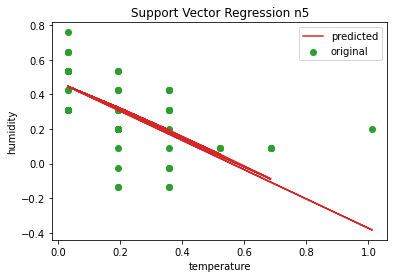

Accuracy of model: n5 === 18.97% (nº of correct predictions)"
Performance of model: n5 === 0.03 (MSE)
How far are the data points from the regression line: M === 0.18 (RMSE)
SCORE:0.7399511556769424
MSE: 0.008464737687744705
RMSE: 0.09200400908517359


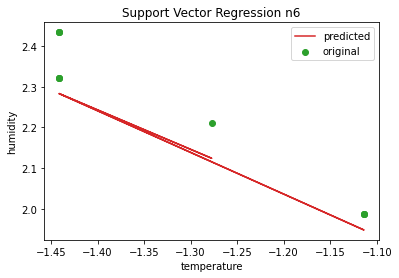

Accuracy of model: n6 === 74.00% (nº of correct predictions)"
Performance of model: n6 === 0.01 (MSE)
How far are the data points from the regression line: M === 0.09 (RMSE)
SCORE:0.6280989356211829
MSE: 0.008328069431901107
RMSE: 0.09125825678754283


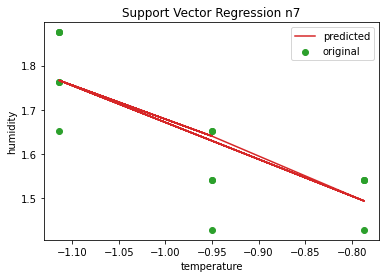

Accuracy of model: n7 === 62.81% (nº of correct predictions)"
Performance of model: n7 === 0.01 (MSE)
How far are the data points from the regression line: M === 0.09 (RMSE)
SCORE:-0.7574347542443509
MSE: 0.049466766708405926
RMSE: 0.22241125580421042


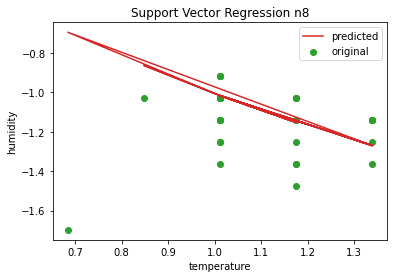

Accuracy of model: n8 === -75.74% (nº of correct predictions)"
Performance of model: n8 === 0.05 (MSE)
How far are the data points from the regression line: M === 0.22 (RMSE)


In [15]:
index_model=0
models_outsiders={}
for k in DO_.keys():
    
    # ni is the node i
    ni = "n"+str(index_model)
    # doi is the dataset corresponding to node i
    doi=DO_[ni]["split"]

    
    models_outsiders[ni]={}
    models_outsiders[ni]["model"],models_outsiders[ni]["score"] = train_model(doi[Xtrain],doi[Ytrain],doi[Xtest],doi[Ytest])
    models_outsiders[ni]["mse"], models_outsiders[ni]["rmse"], models_outsiders[ni]["prediction"] = test_model(models_outsiders[ni]["model"],doi[Xtest],doi[Ytest])
    plot_model(doi[Xtest],doi[Ytest],models_outsiders[ni]["prediction"],ni,xvar,yvar)


    print('Accuracy of model: {} === {:.2f}% (nº of correct predictions)"'.format(ni, models_outsiders[ni]["score"]*100))
    print('Performance of model: {} === {:.2f} (MSE)'.format(ni, models_outsiders[ni]["mse"]))
    print('How far are the data points from the regression line: {} === {:.2f} (RMSE)'.format(M, models_outsiders[ni]["rmse"]))

    index_model = index_model +1

In [34]:
def train_test(d,output,xtest,ytest):
    res={}
    m,score = train_model(d[Xtrain],d[Ytrain],xtest,ytest)
    mse, rmse, ypred = test_model(m,xtest,ytest)
    output.append(mse);
    return output


def do_sa_outer(outersList,ds,_ds):
    experiments={}
    for outer in outersList:
        
        #DO_=generate_outsiders(D_,'percentile',outers)
        
        DO_p = generate_outsiders(ds,'percentile',outer)
        DO_r = generate_outsiders(ds,'random',outer)
        
       
        
        experiments[outer] = {}
        
        
        # Each experiment needs to fix the test data from one node
        for k in ds.keys():
            experiments[outer][k] = {}
            
            eXtest = ds[k]["split"][Xtest]
            eYtest = ds[k]["split"][Ytest]
            
            experiments[outer][k]["full"] = []
            train_test(_ds,experiments[outer][k]['full'],eXtest,eYtest)
            
            experiments[outer][k]["percentile"] = []
            experiments[outer][k]["random"] = []
            experiments[outer][k]["nodes"] = []

            for k1 in ds.keys():

                ni=k1
                
                # Percentil strategy
                di_p=DO_p[ni]["split"]
                train_test(di_p,experiments[outer][k]['percentile'],eXtest,eYtest)
                
                # Random strategy
                di_r=DO_r[ni]["split"]
                train_test(di_r,experiments[outer][k]['random'],eXtest,eYtest)

                # Nodes
                di=ds[ni]["split"]
                train_test(di,experiments[outer][k]['nodes'],eXtest,eYtest)

                
    return experiments

        
        

In [35]:
outersList = [5,7,10,15,17,20,25,30]
#outersList = [15]
experiment1=do_sa_outer(outersList,D_,_D)
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(experiment1)

SCORE:-0.42657274861943195
MSE: 0.044805473596451456
RMSE: 0.21167303464648363
SCORE:0.06987581480529337
MSE: 0.029213129622371565
RMSE: 0.17091848824036435
SCORE:0.037379145298311656
MSE: 0.03023377765379986
RMSE: 0.1738786290887982
SCORE:0.12328558526548505
MSE: 0.027535647655565085
RMSE: 0.16593868643437276
SCORE:-6.436888768578474
MSE: 0.23357611708393905
RMSE: 0.48329713125978624
SCORE:-7.7808548021323745
MSE: 0.2757870976940776
RMSE: 0.5251543560650312
SCORE:-54.9864561447909
MSE: 1.75840992685576
RMSE: 1.3260504993610764
SCORE:-11.598314070993554
MSE: 0.3956849932917719
RMSE: 0.6290349698480776
SCORE:-11.717614516585268
MSE: 0.3994319546508595
RMSE: 0.6320062932051068
SCORE:-13.32413212857283
MSE: 0.44988909573658575
RMSE: 0.6707377249988148
SCORE:-22.27371396739643
MSE: 0.7309755339618716
RMSE: 0.8549710720029489
SCORE:-25.110344284783213
MSE: 0.8200677761286768
RMSE: 0.9055759361470891
SCORE:-28.799924420511545
MSE: 0.9359492728931074
RMSE: 0.9674447130937806
SCORE:-0.33500000

MSE: 5.176431803844515
RMSE: 2.275177312616429
SCORE:-25.934289550397988
MSE: 1.0782312697636138
RMSE: 1.03837915510839
SCORE:-25.93425886520492
MSE: 1.0782300413764823
RMSE: 1.0383785636156413
SCORE:-35.19312368610912
MSE: 1.4488801583484994
RMSE: 1.2036943791297272
SCORE:-56.16398091134302
MSE: 2.288383794473228
RMSE: 1.5127404914502778
SCORE:-56.94152324675379
MSE: 2.3195103054597612
RMSE: 1.5229938625811206
SCORE:-61.55951500077446
MSE: 2.5043773725260254
RMSE: 1.5825224714126576
SCORE:0.7680343753019893
MSE: 0.009286028858925306
RMSE: 0.09636404339236344
SCORE:0.7720597485227517
MSE: 0.009124885448367778
RMSE: 0.09552426628018547
SCORE:0.8216248231993882
MSE: 0.007140700444916353
RMSE: 0.08450266531249978
SCORE:-10.201627759303458
MSE: 0.44842264355009304
RMSE: 0.6696436690883392
SCORE:-10.895102829201992
MSE: 0.47618378065998423
RMSE: 0.690060707952557
SCORE:-74.53138261263436
MSE: 3.0236661126344324
RMSE: 1.7388692051544397
SCORE:-14.259370807878657
MSE: 0.6108618803992071
RMSE:

SCORE:0.5085460602464112
MSE: 0.008735927891125884
RMSE: 0.09346618581672135
SCORE:0.4788517536439624
MSE: 0.009263764378480206
RMSE: 0.09624845130432076
SCORE:-0.42657274861943195
MSE: 0.044805473596451456
RMSE: 0.21167303464648363
SCORE:0.03590479269875435
MSE: 0.03028008378612662
RMSE: 0.1740117346219117
SCORE:0.010217956591994426
MSE: 0.03108685011337604
RMSE: 0.17631463386053933
SCORE:0.12328558526548505
MSE: 0.027535647655565085
RMSE: 0.16593868643437276
SCORE:-6.186059489225402
MSE: 0.2256981279213484
RMSE: 0.47507697052303893
SCORE:-5.123923155597317
MSE: 0.19233879065778456
RMSE: 0.4385644657946931
SCORE:-54.9864561447909
MSE: 1.75840992685576
RMSE: 1.3260504993610764
SCORE:-11.364506656848922
MSE: 0.3883416230141258
RMSE: 0.6231706211096009
SCORE:-10.066234082983502
MSE: 0.34756577223075846
RMSE: 0.5895470907660884
SCORE:-13.32413212857283
MSE: 0.44988909573658575
RMSE: 0.6707377249988148
SCORE:-22.17009767165804
MSE: 0.7277211768270102
RMSE: 0.8530657517606777
SCORE:-20.9706

SCORE:-8.83183679773339
MSE: 0.393587284145464
RMSE: 0.62736535140655
SCORE:-5.034211434836916
MSE: 0.2415610571510392
RMSE: 0.4914886134500363
SCORE:-4.087488027532271
MSE: 0.20366190337299056
RMSE: 0.4512891571631104
SCORE:-10.9644230021337
MSE: 0.4789588001361999
RMSE: 0.6920684938184948
SCORE:-10.557496797584987
MSE: 0.4626687636973453
RMSE: 0.6801975916580014
SCORE:-11.056632976796884
MSE: 0.4826501422775963
RMSE: 0.694730265842504
SCORE:-128.30761419412707
MSE: 5.176431803844515
RMSE: 2.275177312616429
SCORE:-25.87031933049347
MSE: 1.0756704191681064
RMSE: 1.0371453221068427
SCORE:-24.350028683520584
MSE: 1.0148102687034695
RMSE: 1.0073779175182815
SCORE:-35.19312368610912
MSE: 1.4488801583484994
RMSE: 1.2036943791297272
SCORE:-55.699511009813875
MSE: 2.269790173477372
RMSE: 1.5065822823454986
SCORE:-55.842831681762476
MSE: 2.2755275748597015
RMSE: 1.508485192124769
SCORE:-61.55951500077446
MSE: 2.5043773725260254
RMSE: 1.5825224714126576
SCORE:0.769899738295374
MSE: 0.0092113548

MSE: 2.9857513478444546
RMSE: 1.727932680356632
SCORE:-1.419921348092681
MSE: 0.04301574713132499
RMSE: 0.20740237976292603
SCORE:-0.8915138866492351
MSE: 0.03362294526953238
RMSE: 0.18336560547041633
SCORE:-10.026272263172508
MSE: 0.19599948562278882
RMSE: 0.44271829149334774
SCORE:-8.46449632956886
MSE: 0.16823785663900642
RMSE: 0.41016808339875305
SCORE:-2.613532783405711
MSE: 0.06423300186357125
RMSE: 0.25344230480243674
SCORE:-114.14325486235843
MSE: 2.0467496346278864
RMSE: 1.4306465792179026
SCORE:-11.413606362269176
MSE: 0.22066029240497737
RMSE: 0.4697449227027125
SCORE:-9.787124666843054
MSE: 0.1917484745149774
RMSE: 0.4378909390647144
SCORE:-45.28728860579291
MSE: 0.8227880231028036
RMSE: 0.9070766357385707
SCORE:-1.668523920691503
MSE: 0.0474348268702332
RMSE: 0.21779537844094213
SCORE:0.4292109574573113
MSE: 0.010146163278694728
RMSE: 0.10072816527017023
SCORE:-240.1330206359885
MSE: 4.286303374638849
RMSE: 2.0703389516305895
SCORE:-9.707536360670682
MSE: 0.190333738265132

SCORE:-27.961729920251294
MSE: 0.7136366512811098
RMSE: 0.8447701766049212
SCORE:-31.2347770767171
MSE: 0.7942867512115062
RMSE: 0.8912276651964447
SCORE:-38.551960176714296
MSE: 0.9745871013173681
RMSE: 0.9872117813910894
SCORE:-26.32830863694214
MSE: 0.6733880439651169
RMSE: 0.820602244674676
SCORE:-11.967297496125727
MSE: 0.31952299765181946
RMSE: 0.565263653220176
SCORE:-14.678177564603876
MSE: 0.38632091957915254
RMSE: 0.6215471981910565
SCORE:-5.236320816368063
MSE: 0.15366717098606816
RMSE: 0.3920040446042211
SCORE:0.25622681992181673
MSE: 0.018327075178356304
RMSE: 0.1353775283359698
SCORE:0.26507846451022654
MSE: 0.01810896465734125
RMSE: 0.1345695532330447
SCORE:0.24885208577744644
MSE: 0.018508793625195242
RMSE: 0.1360470272560016
SCORE:-96.86094375380102
MSE: 2.4113599700009094
RMSE: 1.5528554246937831
SCORE:-96.31187416057072
MSE: 2.3978305231442434
RMSE: 1.5484929845318136
SCORE:-96.22353100019727
MSE: 2.3956536878065027
RMSE: 1.5477899365891041
SCORE:-35.94031353530939
M

SCORE:-20.87691459431063
MSE: 2.040631139803986
RMSE: 1.428506611746682
SCORE:-20.269920658359464
MSE: 1.984012062098382
RMSE: 1.408549630683414
SCORE:-21.806531900130594
MSE: 2.1273438256436172
RMSE: 1.4585416777190898
SCORE:-40.56178038601179
MSE: 3.876792722107472
RMSE: 1.9689572677200162
SCORE:-41.1420267737981
MSE: 3.930916846538778
RMSE: 1.9826539906243796
SCORE:-42.93390632983871
MSE: 4.098059484732628
RMSE: 2.0243664403295734
SCORE:-2.487562035919566
MSE: 0.32531222178590374
RMSE: 0.5703614834347632
SCORE:-2.316214727243805
MSE: 0.3093293165047223
RMSE: 0.5561738186077463
SCORE:-0.7336627508012987
MSE: 0.161712300880098
RMSE: 0.4021346800266025
SCORE:-15.228630574979828
MSE: 1.513771458260906
RMSE: 1.230354200326437
SCORE:-15.582047832823033
MSE: 1.5467374534696883
RMSE: 1.2436789993682809
SCORE:-69.7092671928913
MSE: 6.595607067189412
RMSE: 2.5681914000302646
SCORE:-14.946435955080894
MSE: 1.4874489562294417
RMSE: 1.2196101656797724
SCORE:-15.565867235364209
MSE: 1.54522816243

SCORE:-32.162579910310036
MSE: 0.8171484417609857
RMSE: 0.9039626329450713
SCORE:-46.92868998480484
MSE: 1.1809954003172272
RMSE: 1.086736122670645
SCORE:-50.1819309029297
MSE: 1.2611574611131164
RMSE: 1.1230126718399558
SCORE:-27.961729920251294
MSE: 0.7136366512811098
RMSE: 0.8447701766049212
SCORE:-34.26621774072
MSE: 0.8689835034418938
RMSE: 0.9321928467017401
SCORE:-50.58683628732546
MSE: 1.2711346041705769
RMSE: 1.1274460537740052
SCORE:-26.32830863694214
MSE: 0.6733880439651169
RMSE: 0.820602244674676
SCORE:-14.705952339837589
MSE: 0.38700530886261214
RMSE: 0.6220975075200126
SCORE:-15.65351447104955
MSE: 0.4103538818954011
RMSE: 0.640588699475257
SCORE:-5.236320816368063
MSE: 0.15366717098606816
RMSE: 0.3920040446042211
SCORE:0.11062231425117341
MSE: 0.021914868867626974
RMSE: 0.14803671459346487
SCORE:0.1181030859967489
MSE: 0.02173053758243749
RMSE: 0.14741281349474844
SCORE:0.24885208577744644
MSE: 0.018508793625195242
RMSE: 0.1360470272560016
SCORE:-96.46184395381167
MSE: 2

SCORE:-20.248279027254917
MSE: 1.9819933776921461
RMSE: 1.4078328656812023
SCORE:-16.217659455881066
MSE: 1.6060259269535537
RMSE: 1.2672907823201247
SCORE:-14.242631486789747
MSE: 1.4217996020603854
RMSE: 1.1923923859453252
SCORE:-16.43453917798217
MSE: 1.62625599699399
RMSE: 1.2752474257939084
SCORE:-15.294663059165366
MSE: 1.5199308251536519
RMSE: 1.2328547461699013
SCORE:-10.259647238237633
MSE: 1.0502754709080901
RMSE: 1.0248294838206453
SCORE:-100.82503656860818
MSE: 9.498018540860384
RMSE: 3.081885549604395
SCORE:-20.273879747703898
MSE: 1.9843813573647089
RMSE: 1.4086807151958562
SCORE:-20.259330662255078
MSE: 1.9830242502326891
RMSE: 1.4081989384432474
SCORE:-21.806531900130594
MSE: 2.1273438256436172
RMSE: 1.4585416777190898
SCORE:-37.52821539243185
MSE: 3.593828359659012
RMSE: 1.8957395284318497
SCORE:-38.93673128365829
MSE: 3.7252116667590425
RMSE: 1.9300807409948015
SCORE:-42.93390632983871
MSE: 4.098059484732628
RMSE: 2.0243664403295734
SCORE:-2.533509760992662
MSE: 0.329

SCORE:-0.2063430950623344
MSE: 0.05576246015830667
RMSE: 0.2361407634405942
SCORE:-0.9243507219054441
MSE: 0.08895191666456735
RMSE: 0.2982480790626611
SCORE:-2.938773252420505
MSE: 0.18206734672722052
RMSE: 0.42669350443523335
SCORE:-0.10870000584232864
MSE: 0.05124896901747728
RMSE: 0.22638235138251675
SCORE:-0.6664455873424815
MSE: 0.07703041203661007
RMSE: 0.2775435317866552
SCORE:-2.1663531527577935
MSE: 0.14636270746728297
RMSE: 0.3825737934925535
SCORE:-62.71339259771598
MSE: 2.9451119924527833
RMSE: 1.7161328597905186
SCORE:0.37367799777815214
MSE: 0.02895134546558
RMSE: 0.1701509490587108
SCORE:0.3098374280787244
MSE: 0.031902336140553766
RMSE: 0.17861225081318965
SCORE:0.5132234870219594
MSE: 0.02250094191448483
RMSE: 0.15000313968209075
SCORE:-4.100620533413391
MSE: 0.23577301552209606
RMSE: 0.48556463578198944
SCORE:-5.2681884278163285
MSE: 0.289743116118061
RMSE: 0.5382779171748187
SCORE:-8.01385345140288
MSE: 0.4166597761565469
RMSE: 0.6454918869796482
SCORE:-16.582637380

MSE: 0.17637892782601192
RMSE: 0.4199749133293701
SCORE:-10.769145348858384
MSE: 0.23121744351421847
RMSE: 0.48085074972824826
SCORE:-10.67020703396666
MSE: 0.22927369453697535
RMSE: 0.4788253277939413
SCORE:-44.784564955832685
MSE: 0.8994867297246167
RMSE: 0.9484127422829244
SCORE:-5.104198271317029
MSE: 0.11992350142355424
RMSE: 0.34629972772665335
SCORE:-6.698549906902681
MSE: 0.1512462439265675
RMSE: 0.388903900631721
SCORE:-5.347603981782772
MSE: 0.12470546684605709
RMSE: 0.3531366121574724
SCORE:-3.312502021721473
MSE: 0.08472371298473765
RMSE: 0.2910733807560177
SCORE:-3.9514035819780853
MSE: 0.0972756172259499
RMSE: 0.311890392968347
SCORE:-6.932553720357169
MSE: 0.15584349903012293
RMSE: 0.3947701850825654
SCORE:-1.8119248749299155
MSE: 0.055243270574307266
RMSE: 0.23503887034766668
SCORE:-1.6576900519952429
MSE: 0.052213162575574595
RMSE: 0.22850199687437
SCORE:-0.4704243139564379
MSE: 0.028888057771088296
RMSE: 0.16996487216801093
SCORE:-9.151492930397655
MSE: 0.199436932219

SCORE:-1.0956843341549014
MSE: 0.03023097512730421
RMSE: 0.17387057004365117
SCORE:-1.542986496140173
MSE: 0.036683464327601216
RMSE: 0.1915292779906018
SCORE:-1.5971221672489526
MSE: 0.03746439020470828
RMSE: 0.1935572013765137
SCORE:-100.61468961033822
MSE: 1.4658272260348029
RMSE: 1.2107135193904472
SCORE:-0.5055589124043156
MSE: 0.021718210749492515
RMSE: 0.14737099697529535
SCORE:-0.6517197298854445
MSE: 0.023826631357427384
RMSE: 0.15435877479893192
SCORE:-0.027686172132104447
MSE: 0.014824730328925456
RMSE: 0.12175684920744892
SCORE:-0.46684886683903226
MSE: 0.02115980488388165
RMSE: 0.145464101701697
SCORE:-0.7734996711228632
MSE: 0.02558334934904112
RMSE: 0.15994795825218
SCORE:-38.33009096179191
MSE: 0.5673502360268442
RMSE: 0.7532265502668133
SCORE:-0.09029754161229109
MSE: 0.01572792110178833
RMSE: 0.12541100869456528
SCORE:-0.5122505232030194
MSE: 0.021814739561737892
RMSE: 0.14769813662242964
SCORE:-6.713637287207647
MSE: 0.11127189967026041
RMSE: 0.33357442898139
SCORE:-

SCORE:-1.1951097100909864
MSE: 0.08099756371583672
RMSE: 0.28460070926797904
SCORE:-1.21075983278639
MSE: 0.08157503909410793
RMSE: 0.28561344347580686
SCORE:-1.2460359720705236
MSE: 0.08287669674073049
RMSE: 0.28788313035106883
SCORE:-4.885804681429686
MSE: 0.2171808714213699
RMSE: 0.4660266853103692
SCORE:-2.231998149235359
MSE: 0.11925780967517406
RMSE: 0.34533724049857994
SCORE:-1.7377780879169782
MSE: 0.10102153623414362
RMSE: 0.31783885261897044
SCORE:-19.236606548181715
MSE: 0.7467124858241032
RMSE: 0.8641252720665582
SCORE:-3.0691809371144574
MSE: 0.15014909765559506
RMSE: 0.38749077105860863
SCORE:-2.044001050280265
MSE: 0.11232088669086612
RMSE: 0.3351430839072561
SCORE:-1.096416418490274
MSE: 0.07735587048382829
RMSE: 0.27812923342185425
SCORE:-8.210622462160526
MSE: 0.3398636415810129
RMSE: 0.5829782513790827
SCORE:-6.021521135169536
MSE: 0.25908778176942016
RMSE: 0.5090066618124169
SCORE:-7.820935821140749
MSE: 0.3254845568409151
RMSE: 0.5705125387236595
SCORE:-1.793591840

SCORE:-0.42657274861943195
MSE: 0.044805473596451456
RMSE: 0.21167303464648363
SCORE:-0.07604196590847545
MSE: 0.03379608221090982
RMSE: 0.1838371078180622
SCORE:-0.11431753020777946
MSE: 0.03499823246035304
RMSE: 0.1870781453306426
SCORE:0.12328558526548505
MSE: 0.027535647655565085
RMSE: 0.16593868643437276
SCORE:-2.595868324704351
MSE: 0.1129382174409092
RMSE: 0.3360628177006632
SCORE:-0.5477346974898589
MSE: 0.04861090062866006
RMSE: 0.22047879859220038
SCORE:-54.9864561447909
MSE: 1.75840992685576
RMSE: 1.3260504993610764
SCORE:-6.6514513477909984
MSE: 0.2403150499473327
RMSE: 0.49021938960768646
SCORE:-3.9623383228679403
MSE: 0.15585599747162457
RMSE: 0.39478601478728265
SCORE:-13.32413212857283
MSE: 0.44988909573658575
RMSE: 0.6707377249988148
SCORE:-22.721742549287146
MSE: 0.7450471141289446
RMSE: 0.8631611171322215
SCORE:-19.688033013748893
MSE: 0.6497650525408444
RMSE: 0.8060800534319432
SCORE:-28.799924420511545
MSE: 0.9359492728931074
RMSE: 0.9674447130937806
SCORE:-0.33261

SCORE:-8.83183679773339
MSE: 0.393587284145464
RMSE: 0.62736535140655
SCORE:-4.167460895223207
MSE: 0.20686337065192836
RMSE: 0.4548223506512497
SCORE:-1.4926495347219193
MSE: 0.09978554169286351
RMSE: 0.31588849566399774
SCORE:-10.9644230021337
MSE: 0.4789588001361999
RMSE: 0.6920684938184948
SCORE:-8.363754683878112
MSE: 0.374849059362091
RMSE: 0.6122491807769864
SCORE:-3.0764287469836997
MSE: 0.16318726119494717
RMSE: 0.4039644306061453
SCORE:-128.30761419412707
MSE: 5.176431803844515
RMSE: 2.275177312616429
SCORE:-19.832910268845872
MSE: 0.833981354882895
RMSE: 0.91322579622068
SCORE:-17.27021094202931
MSE: 0.7313915856593384
RMSE: 0.8552143507094221
SCORE:-35.19312368610912
MSE: 1.4488801583484994
RMSE: 1.2036943791297272
SCORE:-51.24535844245391
MSE: 2.091481903291184
RMSE: 1.446195665631447
SCORE:-49.91708760491282
MSE: 2.038308674085636
RMSE: 1.4276934804381631
SCORE:-61.55951500077446
MSE: 2.5043773725260254
RMSE: 1.5825224714126576
SCORE:0.7031375780947633
MSE: 0.011883972121

SCORE:0.44089440085143927
MSE: 0.009938482129445363
RMSE: 0.09969193613048832
SCORE:-0.370008253992856
MSE: 0.024352828106596676
RMSE: 0.15605392691821848
SCORE:0.10683893097921682
MSE: 0.015876545212026645
RMSE: 0.12600216352121357
SCORE:-166.9683350538316
MSE: 2.9857513478444546
RMSE: 1.727932680356632
SCORE:0.40274774616001574
MSE: 0.010616564850359233
RMSE: 0.10303671603054532
SCORE:0.28800569089838335
MSE: 0.012656182889331078
RMSE: 0.11249970172996494
SCORE:-10.026272263172508
MSE: 0.19599948562278882
RMSE: 0.44271829149334774
SCORE:0.4438598445585189
MSE: 0.00988576935151295
RMSE: 0.09942720629441898
SCORE:0.24938156793419064
MSE: 0.013342752933397357
RMSE: 0.1155108347013273
SCORE:-114.14325486235843
MSE: 2.0467496346278864
RMSE: 1.4306465792179026
SCORE:-0.8293149749025595
MSE: 0.03251731732767907
RMSE: 0.18032558700217524
SCORE:-1.3054037130023888
MSE: 0.04098011831346943
RMSE: 0.20243546703448342
SCORE:-45.28728860579291
MSE: 0.8227880231028036
RMSE: 0.9070766357385707
SCORE

SCORE:-61.08013385313138
MSE: 1.5296965670221723
RMSE: 1.2368090260918103
SCORE:-27.961729920251294
MSE: 0.7136366512811098
RMSE: 0.8447701766049212
SCORE:-35.615915669694715
MSE: 0.9022409750406831
RMSE: 0.9498636612907576
SCORE:-53.53356188333243
MSE: 1.3437439197179992
RMSE: 1.1591996893193162
SCORE:-26.32830863694214
MSE: 0.6733880439651169
RMSE: 0.820602244674676
SCORE:-16.57143058885464
MSE: 0.4329719570680908
RMSE: 0.6580060463765441
SCORE:-19.576215206398377
MSE: 0.5070118862501353
RMSE: 0.7120476713325697
SCORE:-5.236320816368063
MSE: 0.15366717098606816
RMSE: 0.3920040446042211
SCORE:-0.7926714469941625
MSE: 0.04417263926577889
RMSE: 0.21017287947254015
SCORE:-1.074879991565032
MSE: 0.05112644904389051
RMSE: 0.22611158538184306
SCORE:0.24885208577744644
MSE: 0.018508793625195242
RMSE: 0.1360470272560016
SCORE:-91.85161463348227
MSE: 2.2879267058819197
RMSE: 1.5125894042607597
SCORE:-95.78463222919216
MSE: 2.3848389246672173
RMSE: 1.5442923702030058
SCORE:-96.22353100019727
MS

SCORE:-20.248279027254917
MSE: 1.9819933776921461
RMSE: 1.4078328656812023
SCORE:-17.573132884876305
MSE: 1.732461548231881
RMSE: 1.316230051408902
SCORE:-11.028964701098989
MSE: 1.1220357351054076
RMSE: 1.0592618822111024
SCORE:-16.43453917798217
MSE: 1.62625599699399
RMSE: 1.2752474257939084
SCORE:-15.428762914854357
MSE: 1.532439368814253
RMSE: 1.237917351366501
SCORE:-11.491173699354094
MSE: 1.1651495878779674
RMSE: 1.0794209502682295
SCORE:-100.82503656860818
MSE: 9.498018540860384
RMSE: 3.081885549604395
SCORE:-20.45793799524476
MSE: 2.0015499114517334
RMSE: 1.4147614326987195
SCORE:-20.74303367609867
MSE: 2.028143018156342
RMSE: 1.4241288629040356
SCORE:-21.806531900130594
MSE: 2.1273438256436172
RMSE: 1.4585416777190898
SCORE:-32.04709560088505
MSE: 3.0825613946851167
RMSE: 1.7557224708606758
SCORE:-32.058028041493
MSE: 3.0835811490313008
RMSE: 1.7560128555996681
SCORE:-42.93390632983871
MSE: 4.098059484732628
RMSE: 2.0243664403295734
SCORE:-2.723670482269548
MSE: 0.34733590551

                                  2.9451119924527833,
                                  0.02250094191448483,
                                  0.4166597761565469,
                                  1.1031342646267375,
                                  1.4559526958417814,
                                  2.267579187219218,
                                  1.9540684790465481,
                                  3.9078811119316637],
                     'percentile': [   0.08730429245435123,
                                       0.11960374506391996,
                                       0.026777871502330866,
                                       0.48088867450188194,
                                       0.8606493950516059,
                                       0.07618485259781893,
                                       0.07447744419120832,
                                       1.8638855942011125,
                                       0.0970448212724373],
                     'random

                                        0.3550921610572069],
                      'random': [   0.12388896178721531,
                                    0.2293151937365526,
                                    0.761944390777978,
                                    2.1343887281613343,
                                    0.011100123071076265,
                                    0.32624649788349425,
                                    0.3227020779603077,
                                    0.01985679370426327,
                                    0.13434544767160655]},
            'n5': {   'full': [0.08099756371583672],
                      'nodes': [   0.2171808714213699,
                                   0.7467124858241032,
                                   0.07735587048382829,
                                   0.3254845568409151,
                                   0.6319456983988553,
                                   0.03753073994877363,
                                   0.365797

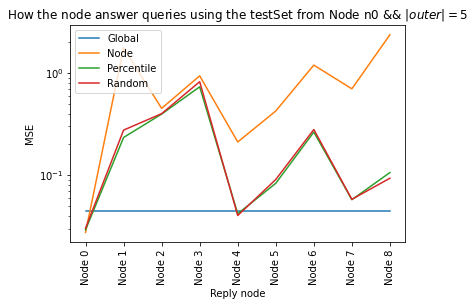

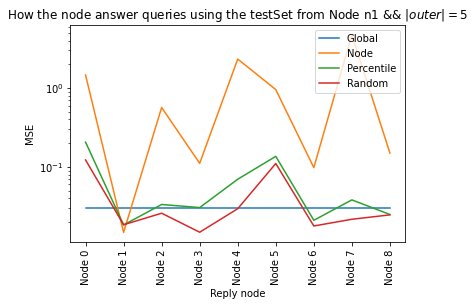

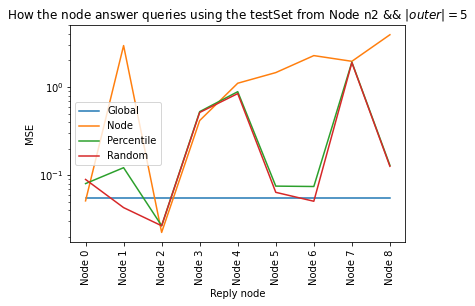

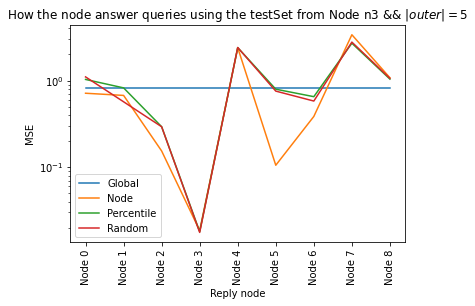

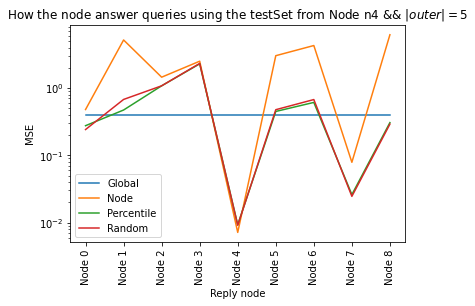

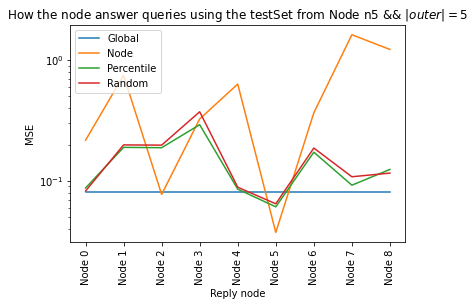

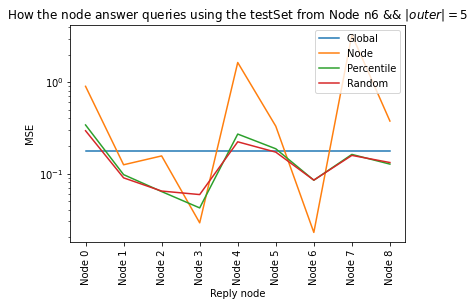

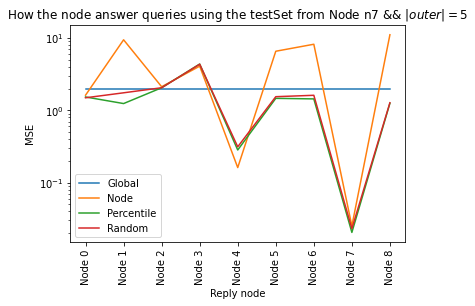

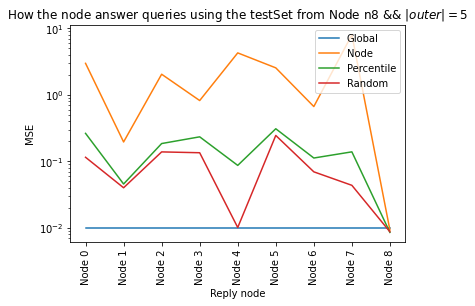

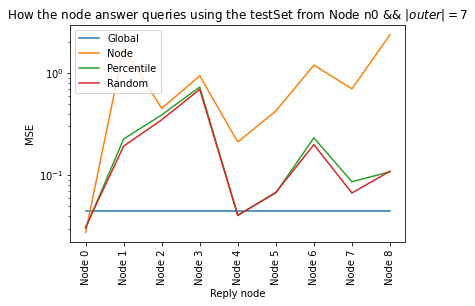

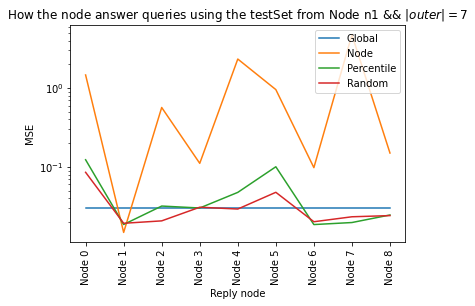

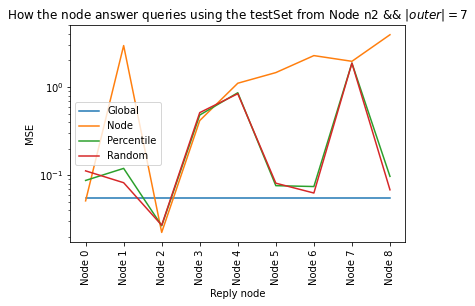

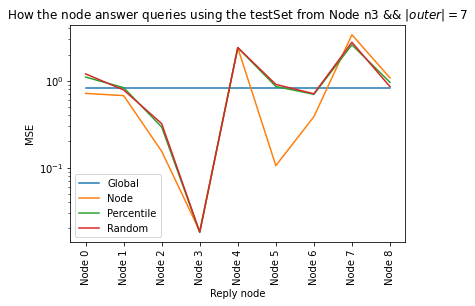

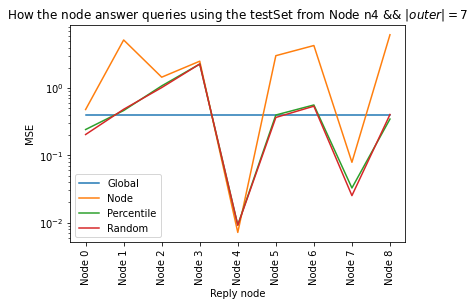

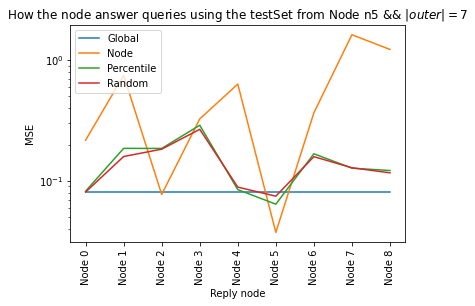

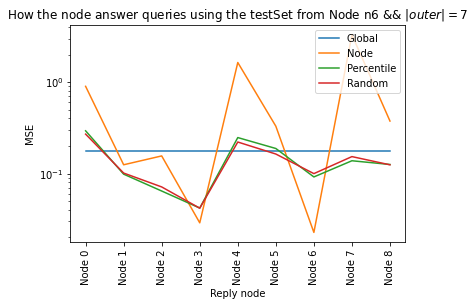

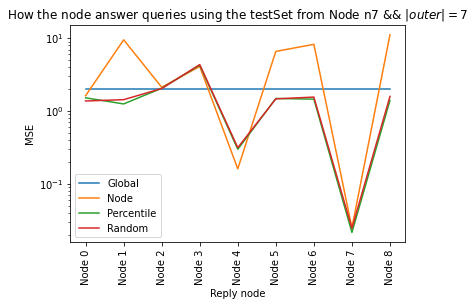

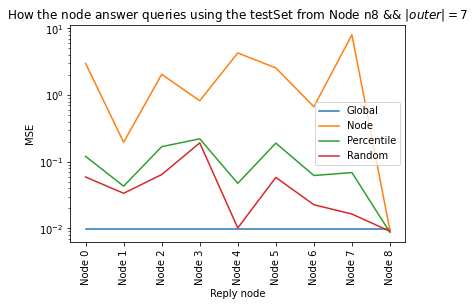

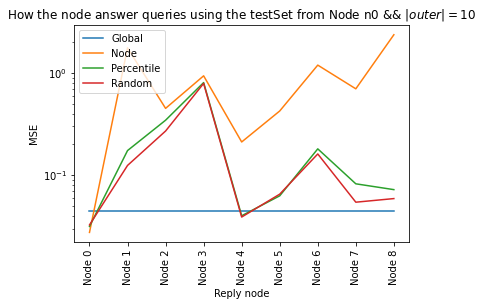

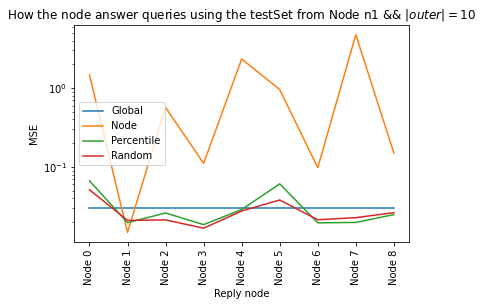

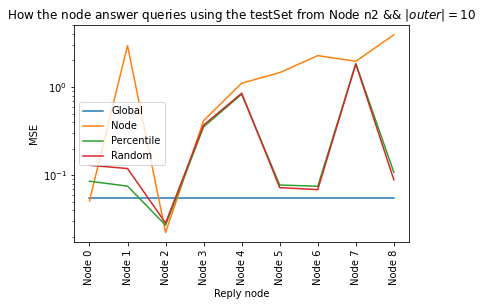

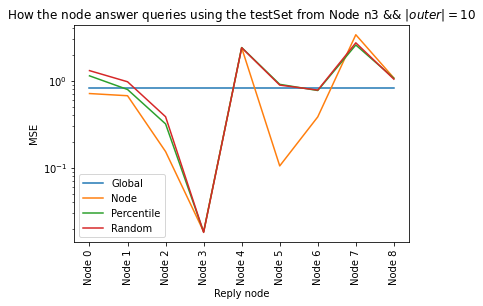

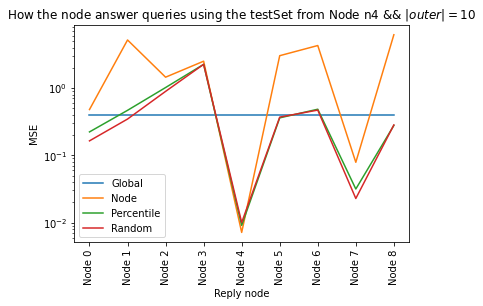

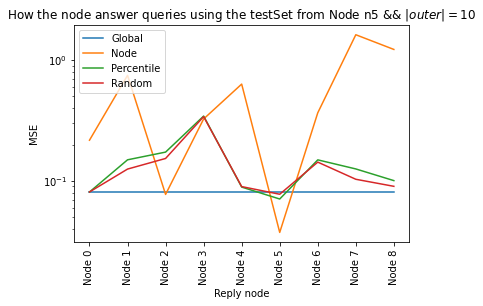

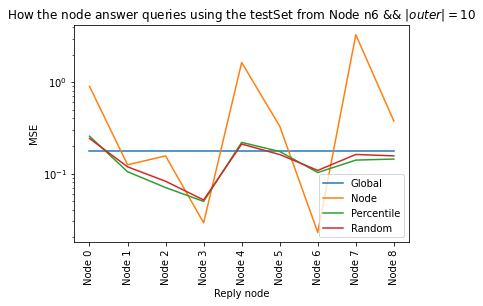

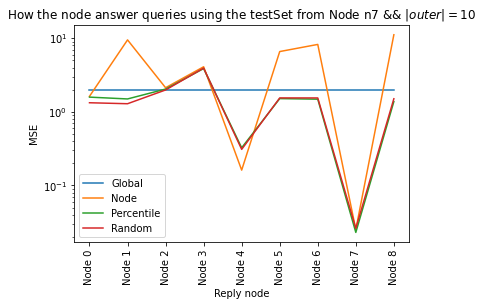

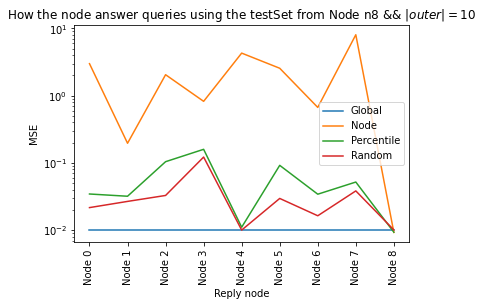

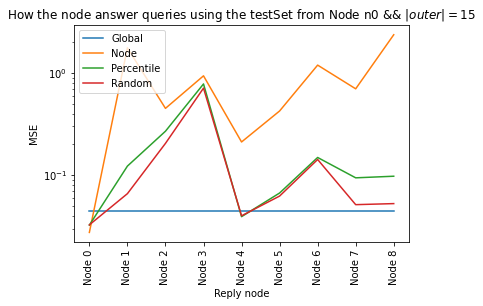

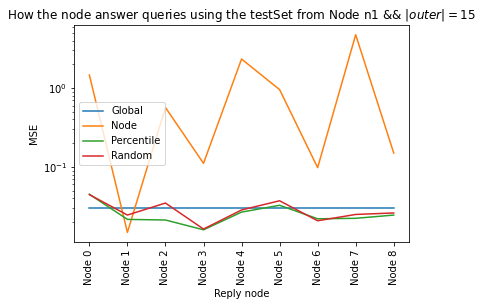

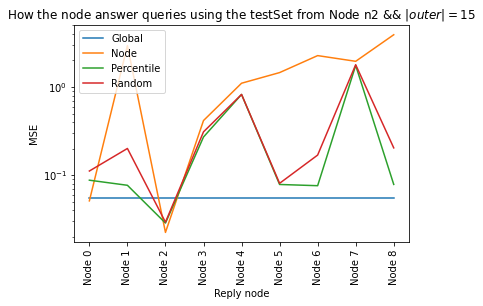

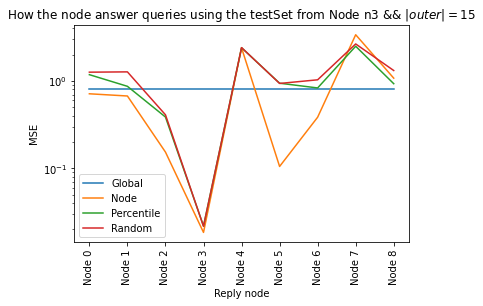

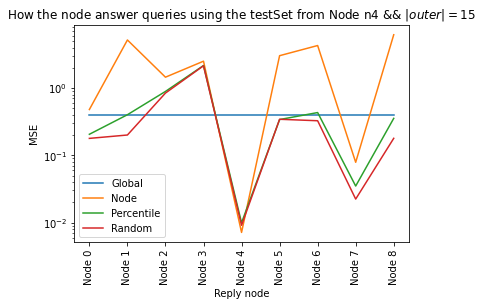

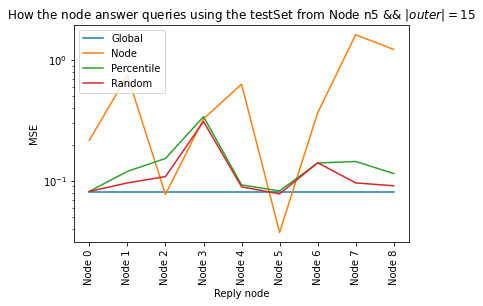

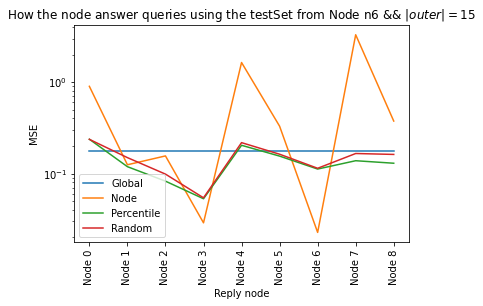

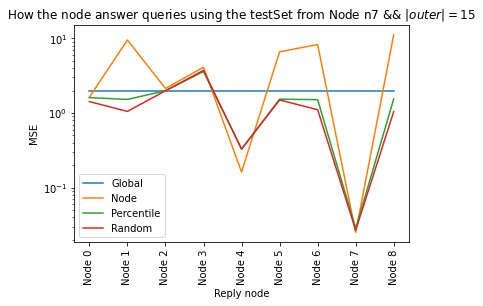

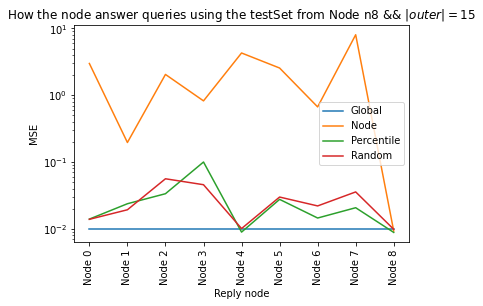

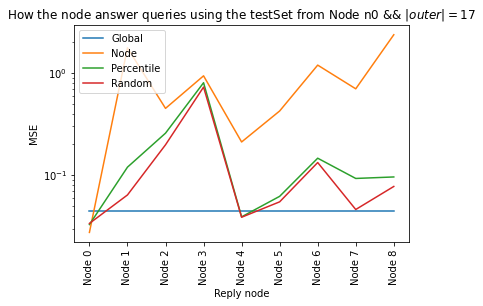

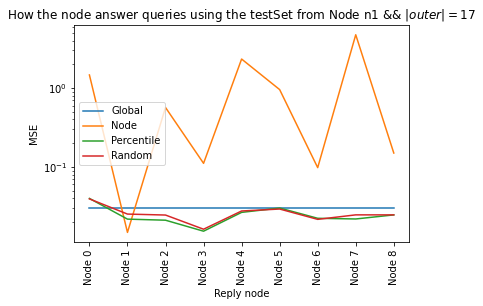

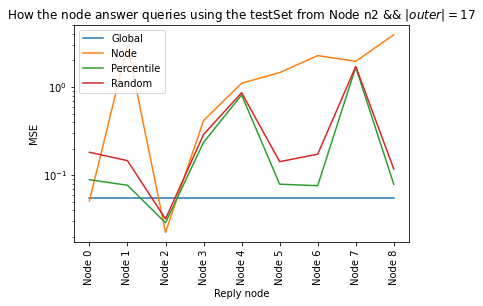

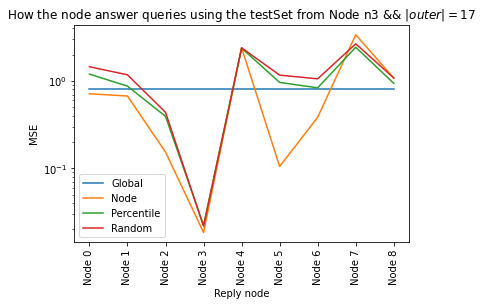

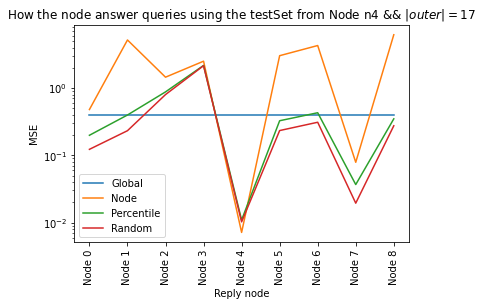

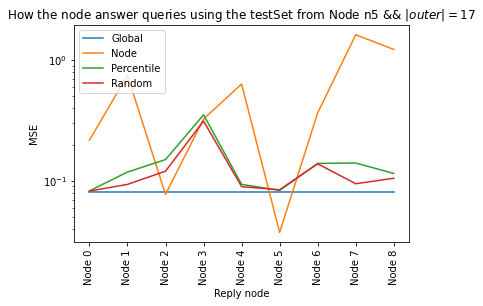

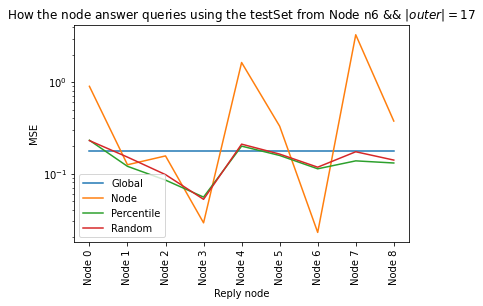

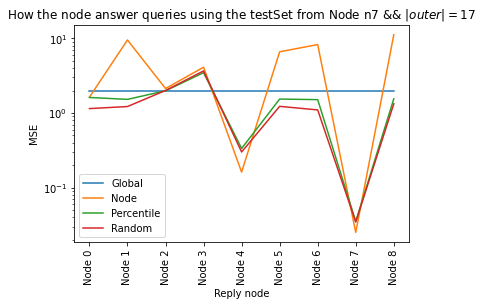

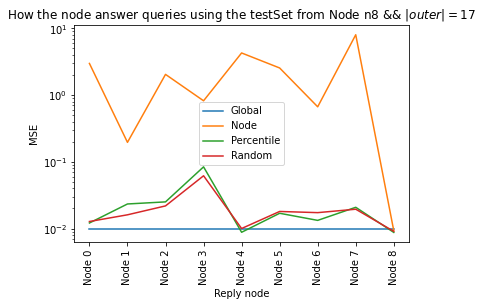

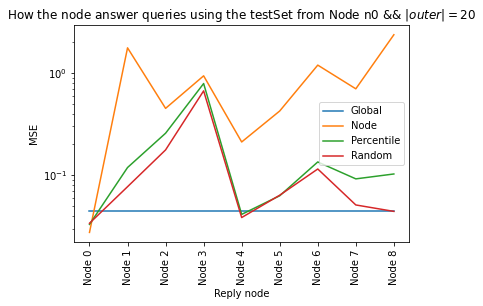

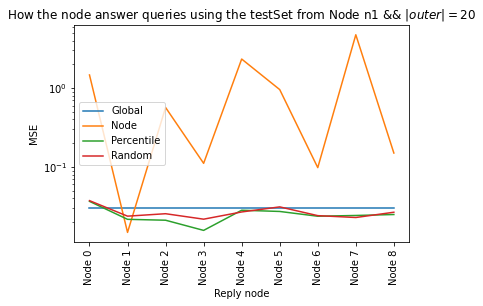

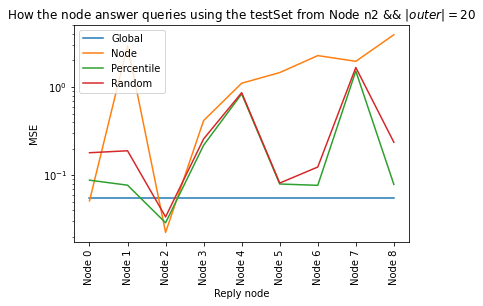

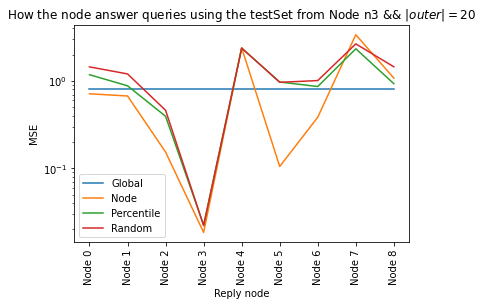

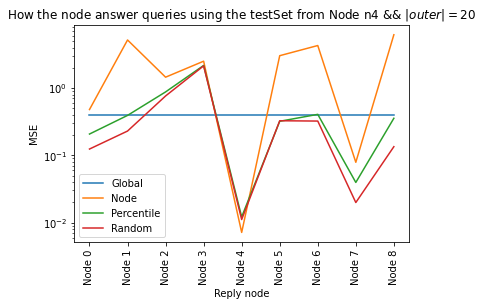

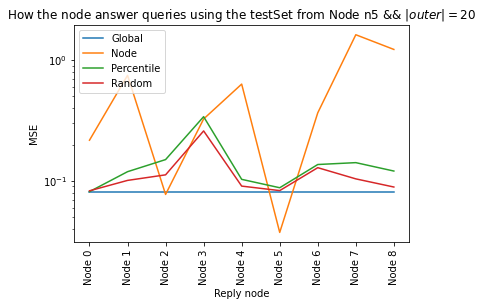

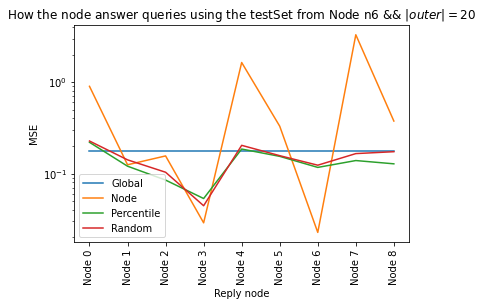

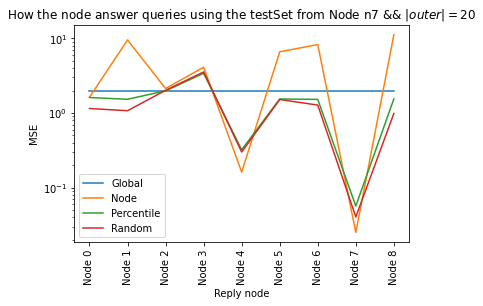

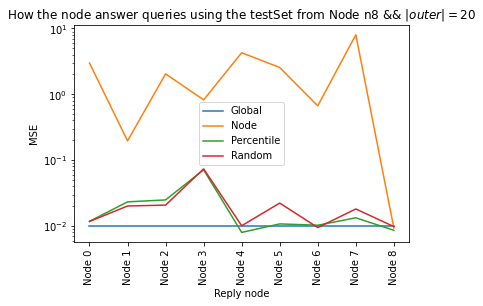

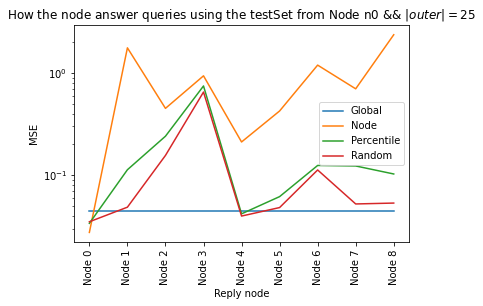

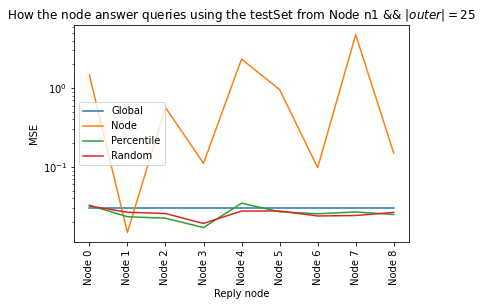

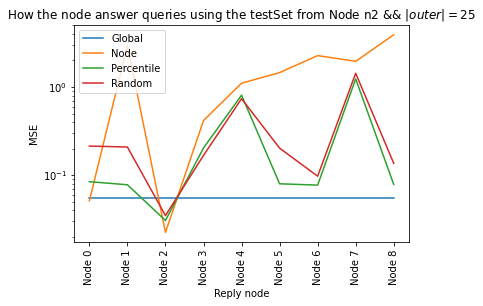

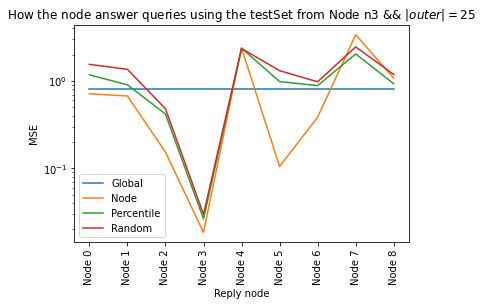

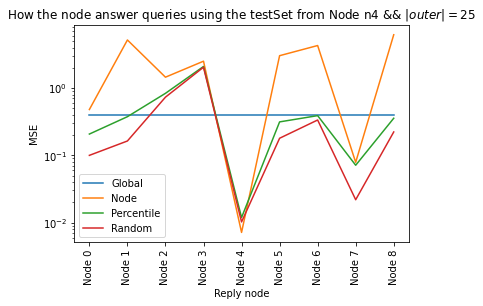

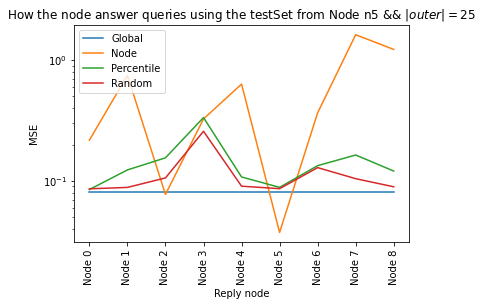

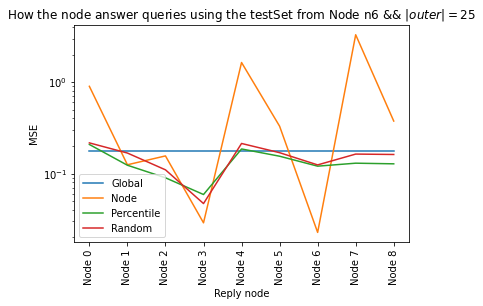

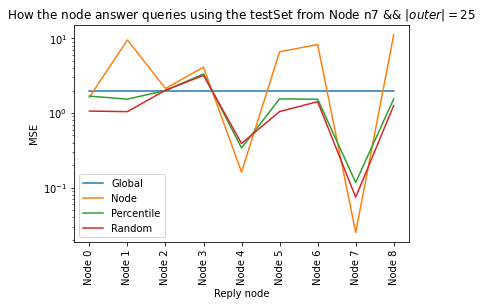

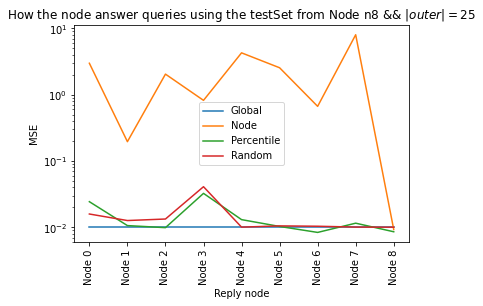

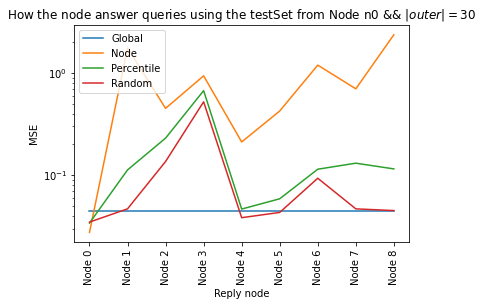

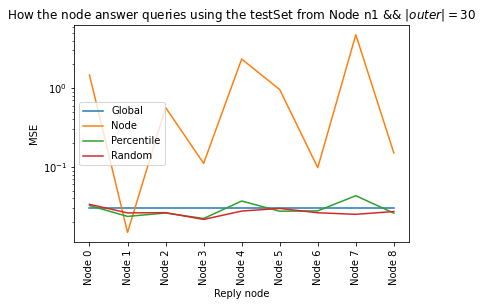

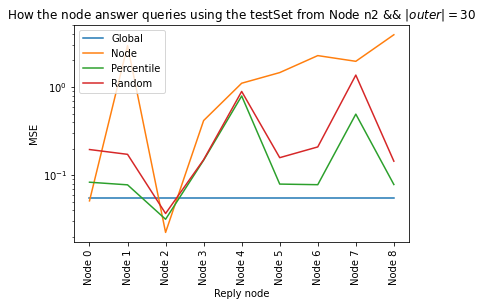

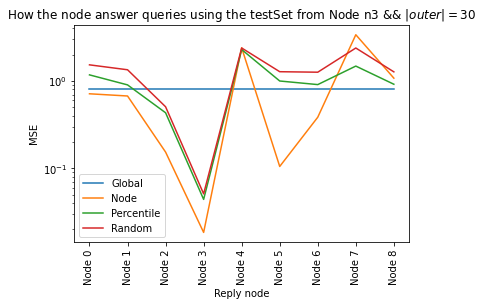

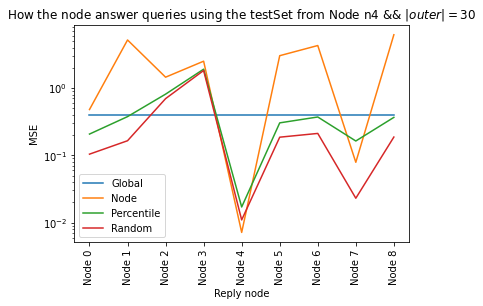

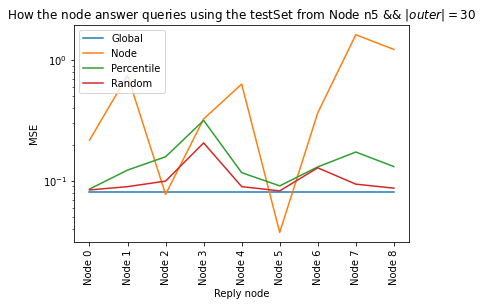

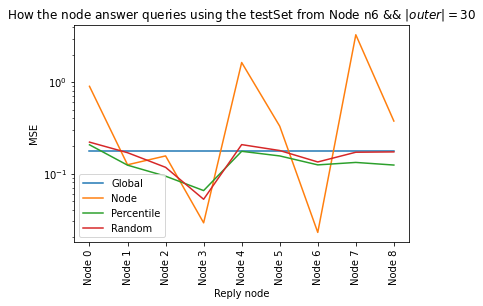

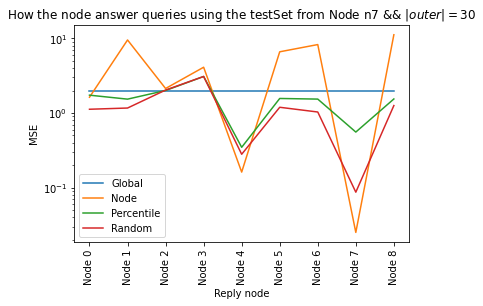

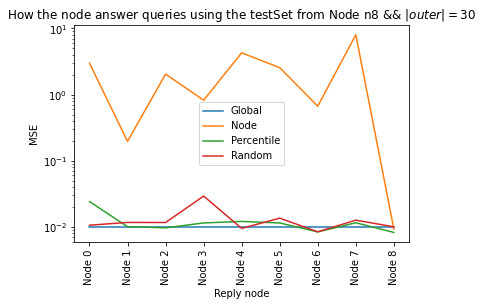

In [36]:
import matplotlib.pyplot as plt

_nodes={}
x=list(range(K))
for o in outersList:
    for test in D_.keys():
        _nodes[o]={}
        
        plt.plot(x, [experiment1[o][test]['full'] for i in range(K)] , label = "Global")
        plt.plot(x, experiment1[o][test]['nodes'] , label = "Node")
        plt.plot(x, experiment1[o][test]['percentile'], label = "Percentile")
        plt.plot(x, experiment1[o][test]['random'], label = "Random")
        plt.title("How the node answer queries using the testSet from Node "
                   +  str(test) + " && $|outer|=$" +str(o))
        plt.ylabel("MSE")
        plt.xlabel("Reply node")
        labels = ["Node "+str(n) for n in x]
        plt.xticks(x, labels, rotation='vertical')
        plt.yscale("log")
        plt.legend()
        plt.show()

{   5: {   'n0': {   'nodes': [   0.027535647655565085,
                                  1.4658272260348029,
                                  0.05124896901747728,
                                  0.7136366512811098,
                                  0.4789588001361999,
                                  0.2171808714213699,
                                  0.8994867297246167,
                                  1.62625599699399,
                                  2.9857513478444546],
                     'percentile': [   0.029213129622371565,
                                       0.20648196270647637,
                                       0.08042984528831425,
                                       1.03019260693077,
                                       0.2754644180500459,
                                       0.08742528684685782,
                                       0.33989465205464775,
                                       1.5353936334357916,
                                    

    17: {   'n0': {   'nodes': [   0.027535647655565085,
                                   1.4658272260348029,
                                   0.05124896901747728,
                                   0.7136366512811098,
                                   0.4789588001361999,
                                   0.2171808714213699,
                                   0.8994867297246167,
                                   1.62625599699399,
                                   2.9857513478444546],
                      'percentile': [   0.03286545058657606,
                                        0.03997831530661877,
                                        0.08895191666456735,
                                        1.1979955181017337,
                                        0.19844543263909584,
                                        0.0826677407751461,
                                        0.23121744351421847,
                                        1.6143298023489516,
                  

                                    0.024287381796420756,
                                    1.430304772464873,
                                    2.455151923824508,
                                    0.021859866624316087,
                                    0.10439420710400657,
                                    0.16322576498196925,
                                    0.07467200889415145,
                                    0.01008158030728703]},
            'n8': {   'nodes': [   2.361238542140798,
                                   0.1502376231684024,
                                   3.9078811119316637,
                                   1.0771028448067792,
                                   6.192313434258597,
                                   1.2224444740911602,
                                   0.3750068402643082,
                                   11.158895946858705,
                                   0.009263764378480206],
                      'percentile': [   0.102666

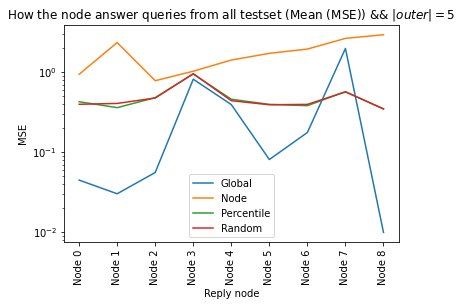

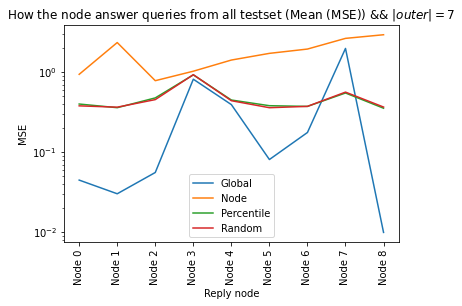

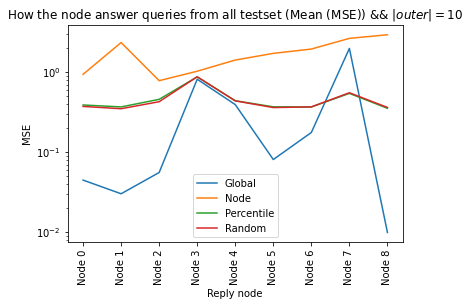

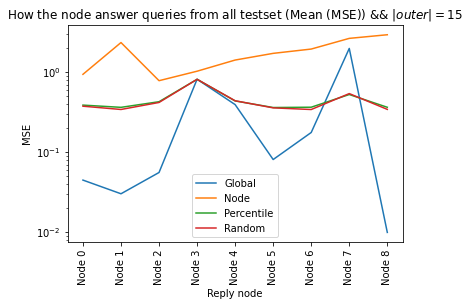

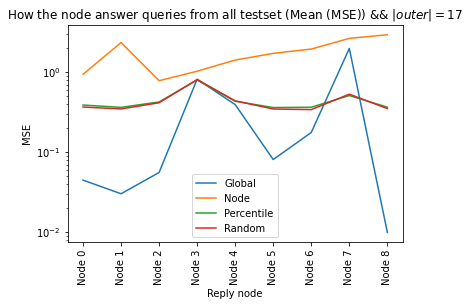

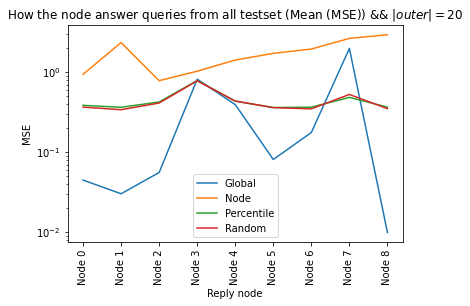

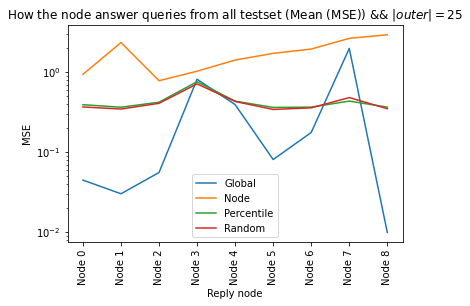

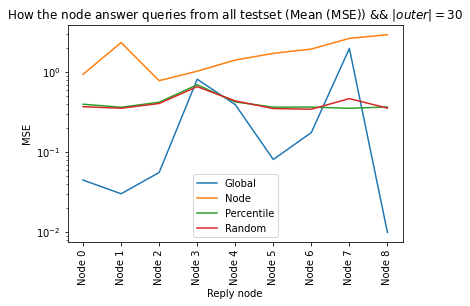

In [37]:
_nodes={}
for o in outersList:
    _nodes[o]={}
  
    for z in D_.keys(): 
        _nodes[o][z]={}
        _nodes[o][z]['nodes']=[]
        _nodes[o][z]['percentile']=[]
        _nodes[o][z]['random']=[]
        
    for k in D_.keys(): 
        ik1=0
        for k1 in D_.keys(): 
            _nodes[o][k1]['nodes'].append(experiment1[o][k]['nodes'][ik1])
            _nodes[o][k1]['percentile'].append(experiment1[o][k]['percentile'][ik1])
            _nodes[o][k1]['random'].append(experiment1[o][k]['random'][ik1])
            ik1=ik1+1
            
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(_nodes)

from functools import reduce
  
def Average(lst):
    return reduce(lambda a, b: a + b, lst) / len(lst)

x=list(range(K))
for o in outersList:
        #_res = experiments[outer][test]
        mean_nodes=[]
        mean_percentile=[]
        mean_random=[]
        full=[]
        for k in D_.keys():
            mean_nodes.append(Average(_nodes[o][k]['nodes']))
            mean_percentile.append(Average(_nodes[o][k]['percentile']))
            mean_random.append(Average(_nodes[o][k]['random']))
            full.append(experiment1[o][k]['full'])
        
              
        plt.plot(x, full , label = "Global")
        plt.plot(x, mean_nodes , label = "Node")
        plt.plot(x, mean_percentile, label = "Percentile")
        plt.plot(x, mean_random, label = "Random")
        plt.title("How the node answer queries from all testset (Mean (MSE)) && $|outer|=$" +str(o))
        plt.ylabel("MSE")
        plt.xlabel("Reply node")
        labels = ["Node "+str(n) for n in x]
        plt.xticks(x, labels, rotation='vertical')
        plt.yscale("log")
        plt.legend()
        plt.show()

In [ ]:
import pprint
pp = pprint.PrettyPrinter(indent=4)
pp.pprint(experiment1)